In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.cluster import AgglomerativeClustering

from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)

In [2]:
accounts_df = pd.read_csv('../data/accounts.csv')
data_dictionary_df = pd.read_csv('../data/data_dictionary.csv')
products_df = pd.read_csv('../data/products.csv')
sales_pipeline_df = pd.read_csv('../data/sales_pipeline.csv')
sales_teams_df = pd.read_csv('../data/sales_teams.csv')

# Exploratory data analysis

In [3]:
accounts_df['office_location'].value_counts()

office_location
United States    71
Kenya             1
Philipines        1
Japan             1
Italy             1
Norway            1
Korea             1
Jordan            1
Brazil            1
Germany           1
Panama            1
Belgium           1
Romania           1
Poland            1
China             1
Name: count, dtype: int64

In [4]:
accounts_df[accounts_df['office_location'] == 'Brazil']

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
49,Nam-zim,services,1987,405.59,1179,Brazil,Warephase


In [5]:
sales_pipeline_df.account.value_counts()

account
Hottechi                 200
Kan-code                 196
Konex                    178
Condax                   170
Dontechi                 129
                        ... 
Newex                     55
Bioplex                   53
The New York Inquirer     52
Sumace                    52
Iselectrics               51
Name: count, Length: 85, dtype: int64

'accounts_df' represents information about our clients 

In [6]:
products_df

,product,series,sales_price
0,GTX Basic,GTX,550
1,GTX Pro,GTX,4821
2,MG Special,MG,55
3,MG Advanced,MG,3393
4,GTX Plus Pro,GTX,5482
5,GTX Plus Basic,GTX,1096
6,GTK 500,GTK,26768


Base sale price for all products from the company

In [7]:
sales_pipeline_df.head(20)

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0
5,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0
6,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0
7,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0
8,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0
9,HAXMC4IX,James Ascencio,MG Advanced,NaN,Engaging,2016-11-03,NaN,NaN


In [8]:
sales_pipeline_df.isnull().sum()

opportunity_id       0
sales_agent          0
product              0
account           1425
deal_stage           0
engage_date        500
close_date        2089
close_value       2089
dtype: int64

In [9]:
sales_pipeline_df[sales_pipeline_df['deal_stage'] == 'Engaging'].isnull().sum()

opportunity_id       0
sales_agent          0
product              0
account           1088
deal_stage           0
engage_date          0
close_date        1589
close_value       1589
dtype: int64

In [10]:
len(sales_pipeline_df[sales_pipeline_df['deal_stage'] == 'Engaging'])

1589

In [11]:
len(sales_pipeline_df)

8800

In [12]:
data_dictionary_df

,Table,Field,Description
0,accounts,account,Company name
1,accounts,sector,Industry
2,accounts,year_established,Year Established
3,accounts,revenue,Annual revenue (in millions of USD)
4,accounts,employees,Number of employees
5,accounts,office_location,Headquarters
6,accounts,subsidiary_of,Parent company
7,products,product,Product name
8,products,series,Product series
9,products,sales_price,Suggested retail price


In [13]:
sales_pipeline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opportunity_id  8800 non-null   object 
 1   sales_agent     8800 non-null   object 
 2   product         8800 non-null   object 
 3   account         7375 non-null   object 
 4   deal_stage      8800 non-null   object 
 5   engage_date     8300 non-null   object 
 6   close_date      6711 non-null   object 
 7   close_value     6711 non-null   float64
dtypes: float64(1), object(7)
memory usage: 550.1+ KB


## Customers per Country

In [14]:
accounts_df.columns

Index(['account', 'sector', 'year_established', 'revenue', 'employees',
       'office_location', 'subsidiary_of'],
      dtype='object')

In [15]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

accounts_sales_pipeline_df = pd.merge(sales_pipeline_df, accounts_df, on='account', how='inner')

world_map = accounts_sales_pipeline_df[['account', 'sector', 'office_location']].groupby(
    ['account', 'sector', 'office_location']
).count().reset_index(drop=False)

countries = world_map['office_location'].value_counts()

choromap = go.Figure(data=go.Choropleth(
    locations=countries.index,  # Nomes dos países
    locationmode='country names',
    z=countries.values,  # Número de pedidos
    text=countries.index,  # Tooltip com os nomes dos países
    colorscale='Viridis',
    colorbar_title='Qtd Customers'
))

choromap.update_layout(
    title={
        'text': "Number of Customers by Countries",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    geo=dict(
        resolution=50,
        showocean=True,
        oceancolor="LightBlue",
        showland=True,
        landcolor="whitesmoke",
        showframe=True
    ),
    template='plotly_white',
    height=600,
    width=1000
)

# Mostrar o gráfico
choromap.show()

## Engage Date vs. Close Date

In [16]:
missing_percentage_engage_date = sales_pipeline_df['engage_date'].isna().mean() * 100
missing_percentage_close_date = sales_pipeline_df['close_date'].isna().mean() * 100
print(missing_percentage_engage_date)
print(missing_percentage_close_date)

5.681818181818182
23.738636363636363


In [17]:
sales_pipeline_df[sales_pipeline_df['engage_date'].isna()].head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
8300,6CWZFOHJ,Anna Snelling,GTX Basic,Green-Plus,Prospecting,NaN,NaN,NaN
8301,3LCLVRVV,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN
8302,YIU1B39V,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN
8303,8E0VRCLW,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN
8304,G99CS23F,Anna Snelling,GTX Basic,NaN,Prospecting,NaN,NaN,NaN


In [18]:
sales_pipeline_df.loc[sales_pipeline_df['product'] == 'GTXPro', 'product'] = 'GTX Pro'
sales_pipeline_df['product'].value_counts()

product
GTX Basic         1866
MG Special        1651
GTX Pro           1480
MG Advanced       1412
GTX Plus Basic    1383
GTX Plus Pro       968
GTK 500             40
Name: count, dtype: int64

In [19]:
sales_pipeline_df['deal_stage'].value_counts()

deal_stage
Won            4238
Lost           2473
Engaging       1589
Prospecting     500
Name: count, dtype: int64

In [20]:
prospecting_df = sales_pipeline_df[sales_pipeline_df['deal_stage'] == 'Prospecting']
len(prospecting_df) == int(prospecting_df['engage_date'].isna().sum())

True

All Prospecting deal stages don't have a engage_date and close_date

Selecting the dates of concluded deal stage for time series visualization:

In [21]:
engage_time_df = sales_pipeline_df[(sales_pipeline_df['deal_stage'] == 'Won') | (sales_pipeline_df['deal_stage'] == 'Lost')]
print(engage_time_df['engage_date'].isna().mean() * 100)
print(engage_time_df['close_value'].isna().mean() * 100)

0.0
0.0


No data missing from closed deal stages

In [22]:
engage_time_df['engage_date'] = pd.to_datetime(engage_time_df['engage_date'])
engage_time_df['close_date'] = pd.to_datetime(engage_time_df['close_date'])

Creating a sales cycle duration. With this we can visualize a stage duration

In [23]:
engage_time_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6711 entries, 0 to 8299
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   opportunity_id  6711 non-null   object        
 1   sales_agent     6711 non-null   object        
 2   product         6711 non-null   object        
 3   account         6711 non-null   object        
 4   deal_stage      6711 non-null   object        
 5   engage_date     6711 non-null   datetime64[ns]
 6   close_date      6711 non-null   datetime64[ns]
 7   close_value     6711 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 471.9+ KB


In [24]:
engage_time_df['sales_cycle_duration'] = (engage_time_df['close_date'] - engage_time_df['engage_date']).dt.days
engage_time_df['sales_cycle_duration']

0       132
1       137
2       133
3       135
4       128
       ... 
8295      2
8296      6
8297      3
8298      3
8299      2
Name: sales_cycle_duration, Length: 6711, dtype: int64

In [25]:
engage_time_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6711 entries, 0 to 8299
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   opportunity_id        6711 non-null   object        
 1   sales_agent           6711 non-null   object        
 2   product               6711 non-null   object        
 3   account               6711 non-null   object        
 4   deal_stage            6711 non-null   object        
 5   engage_date           6711 non-null   datetime64[ns]
 6   close_date            6711 non-null   datetime64[ns]
 7   close_value           6711 non-null   float64       
 8   sales_cycle_duration  6711 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 524.3+ KB


### Distribution of the Sales Cycle by deal stage

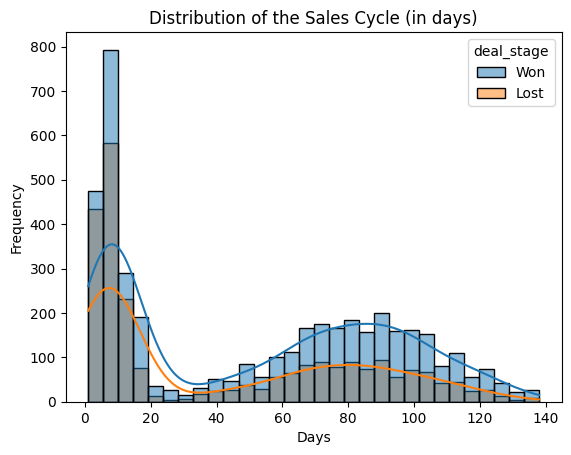

In [26]:
sns.histplot(x=engage_time_df['sales_cycle_duration'], kde=True, bins=30, hue=engage_time_df['deal_stage'])
plt.title('Distribution of the Sales Cycle (in days)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

Same frequency variation a long time for both deal stages.

### Distribution of the Sales Cycle by product

In [27]:
engage_time_df['product'].value_counts()

product
GTX Basic         1436
MG Special        1223
GTX Pro           1147
MG Advanced       1084
GTX Plus Basic    1051
GTX Plus Pro       745
GTK 500             25
Name: count, dtype: int64

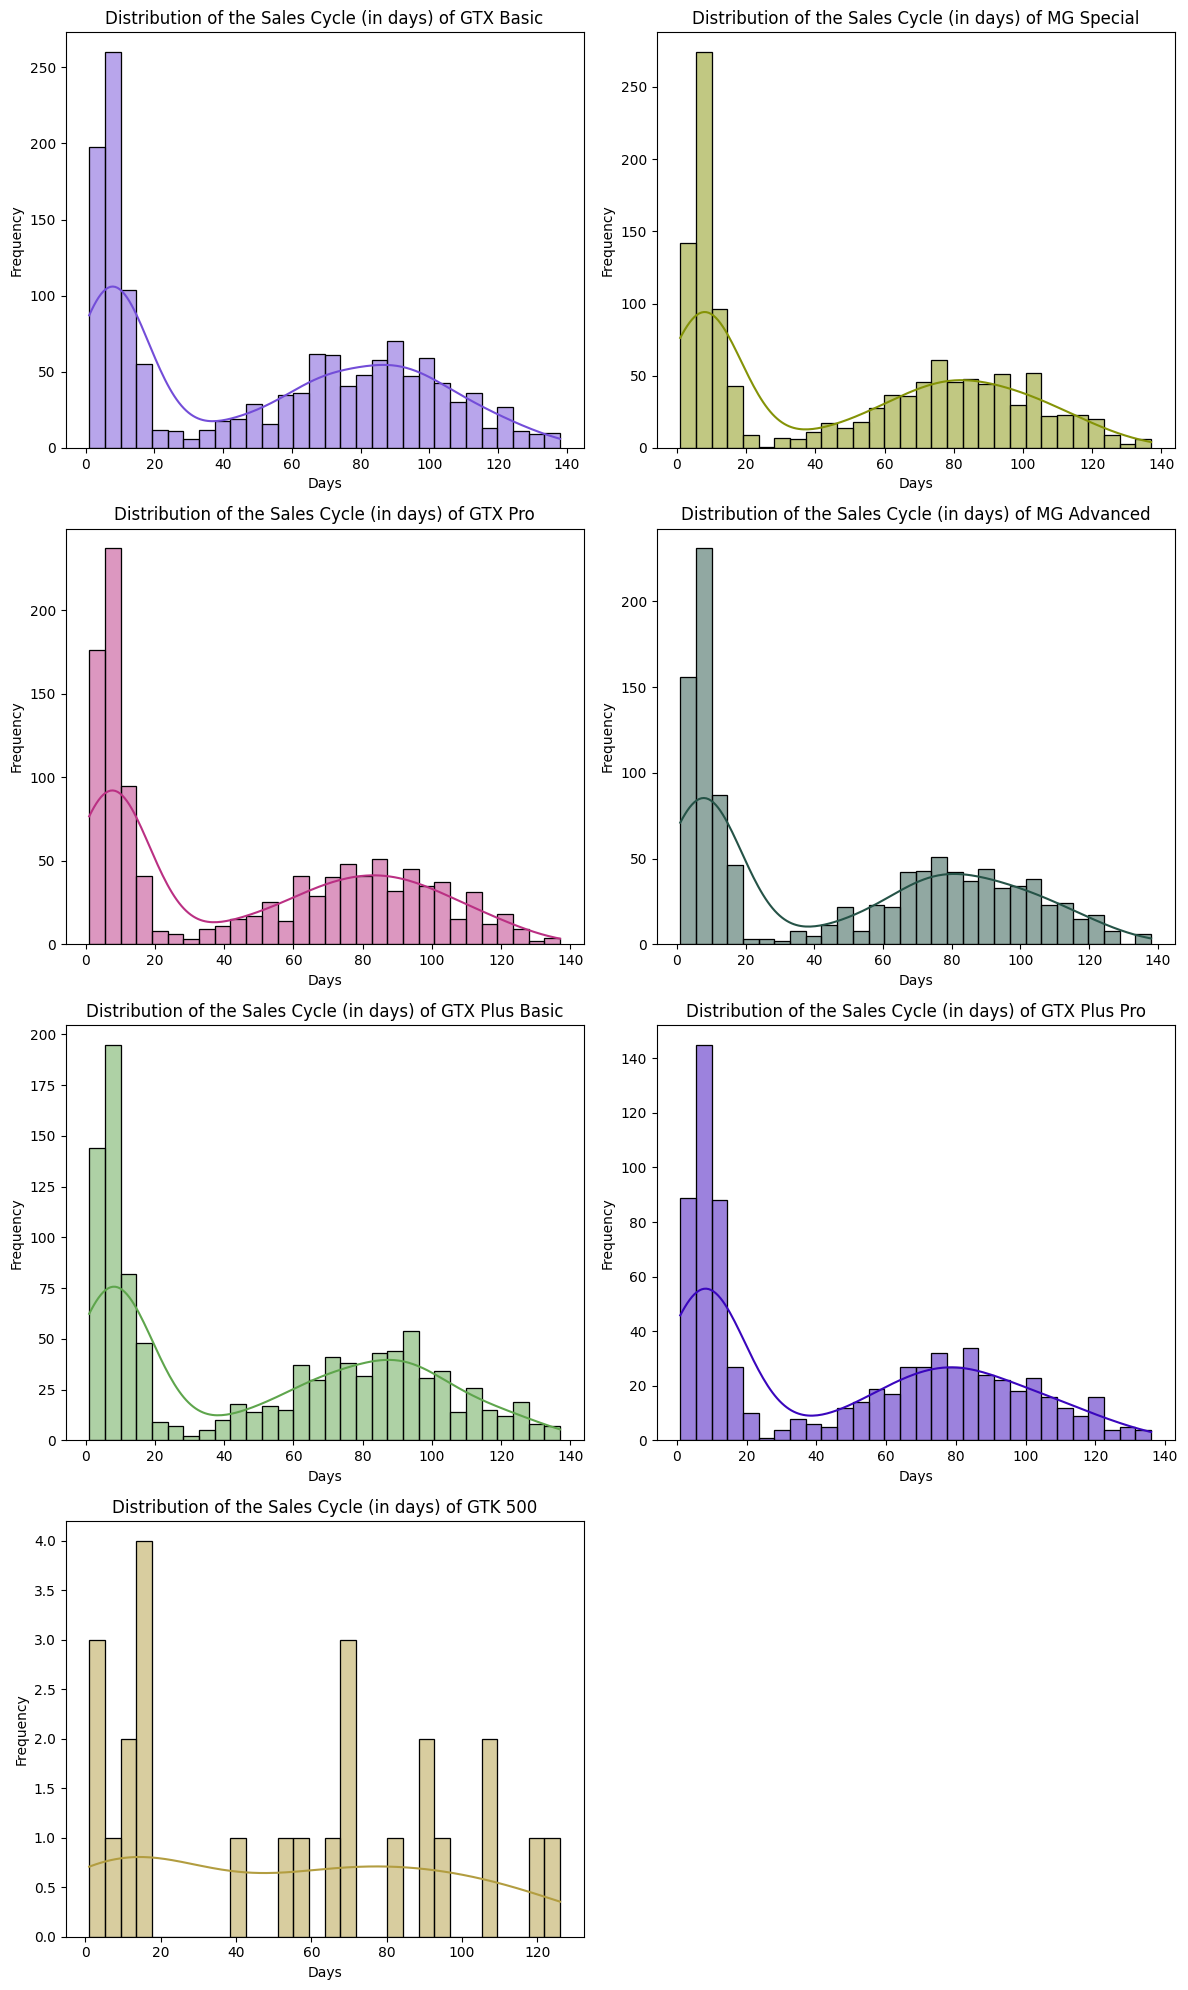

In [28]:
products_from_stages = [
    'GTX Basic', 
    'MG Special',
    'GTX Pro',
    'MG Advanced',
    'GTX Plus Basic',
    'GTX Plus Pro',
    'GTK 500'
]

n_cols = 2
n_rows = (len(products_from_stages) + 1) // n_cols

colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in products_from_stages]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()  # Achatar a matriz de eixos para facilitar o acesso

for i, product in enumerate(products_from_stages):
    ax = axes[i]
    sns.histplot(
        x=engage_time_df[engage_time_df['product'] == product]['sales_cycle_duration'], 
        kde=True, 
        bins=30, 
        color=colors[i], 
        ax=ax
    )
    ax.set_title(f'Distribution of the Sales Cycle (in days) of {product}', fontsize=12)
    ax.set_xlabel('Days', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

for j in range(len(products_from_stages), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Time Trend Analysis

### Time Trend Analysis by deal stage

In [29]:
time_series_engage_date = engage_time_df.groupby(engage_time_df['engage_date'].dt.to_period('M')).size()
time_series_close_date = engage_time_df.groupby(engage_time_df['close_date'].dt.to_period('M')).size()

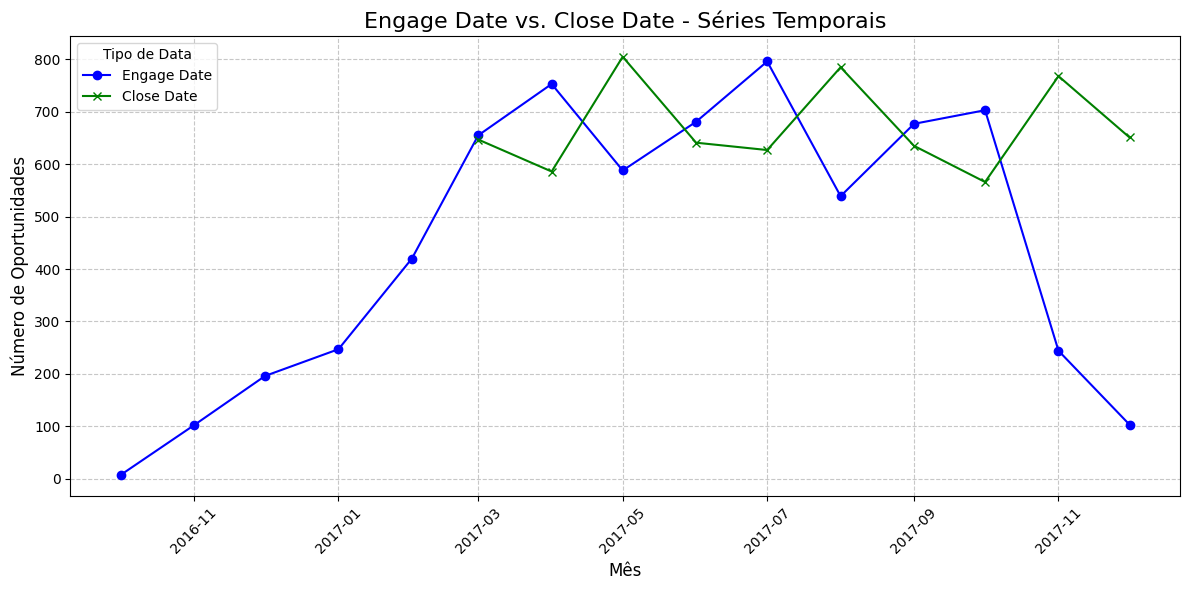

In [30]:
time_series_engage_date.index = time_series_engage_date.index.to_timestamp()
time_series_close_date.index = time_series_close_date.index.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(time_series_engage_date.index, time_series_engage_date.values, label='Engage Date', color='blue', marker='o')
plt.plot(time_series_close_date.index, time_series_close_date.values, label='Close Date', color='green', marker='x')

plt.title('Engage Date vs. Close Date - Séries Temporais', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Oportunidades', fontsize=12)
plt.legend(title='Tipo de Data', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Time Trend Analysis by deal stage

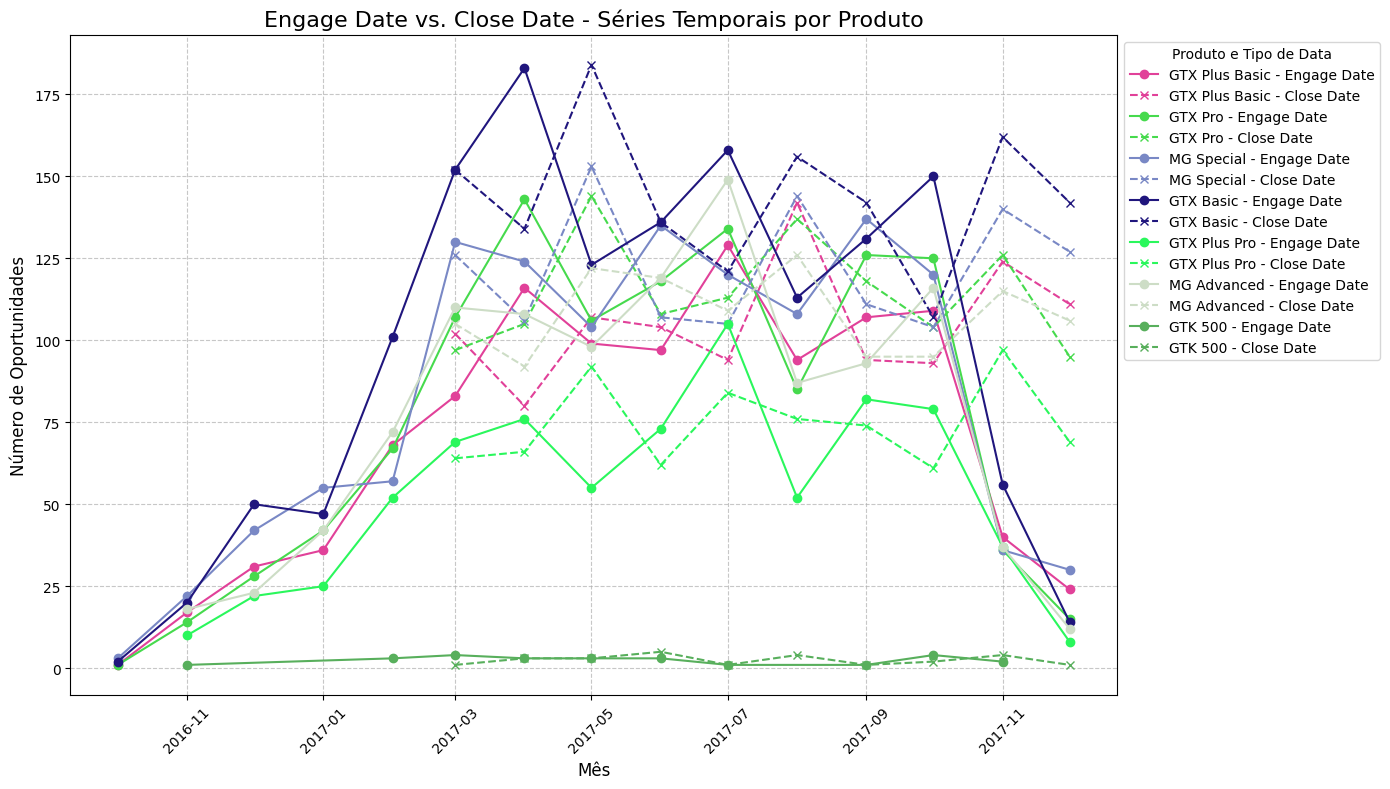

In [31]:
plt.figure(figsize=(14, 8))

products = engage_time_df['product'].unique()
colors = {product: f'#{random.randint(0, 0xFFFFFF):06x}' for product in products}

for product in products:
    product_data = engage_time_df[engage_time_df['product'] == product]

    time_series_engage_date = product_data.groupby(product_data['engage_date'].dt.to_period('M')).size()
    time_series_close_date = product_data.groupby(product_data['close_date'].dt.to_period('M')).size()

    time_series_engage_date.index = time_series_engage_date.index.to_timestamp()
    time_series_close_date.index = time_series_close_date.index.to_timestamp()

    plt.plot(
        time_series_engage_date.index, 
        time_series_engage_date.values, 
        label=f'{product} - Engage Date', 
        color=colors[product], 
        marker='o', 
        linestyle='-'
    )
    plt.plot(
        time_series_close_date.index, 
        time_series_close_date.values, 
        label=f'{product} - Close Date', 
        color=colors[product], 
        marker='x', 
        linestyle='--'
    )

plt.title('Engage Date vs. Close Date - Séries Temporais por Produto', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Oportunidades', fontsize=12)
plt.legend(title='Produto e Tipo de Data', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sales agent performance

### Closing Fee per Agent

Closing rate is the number of opportunities won over the total number of opportunities

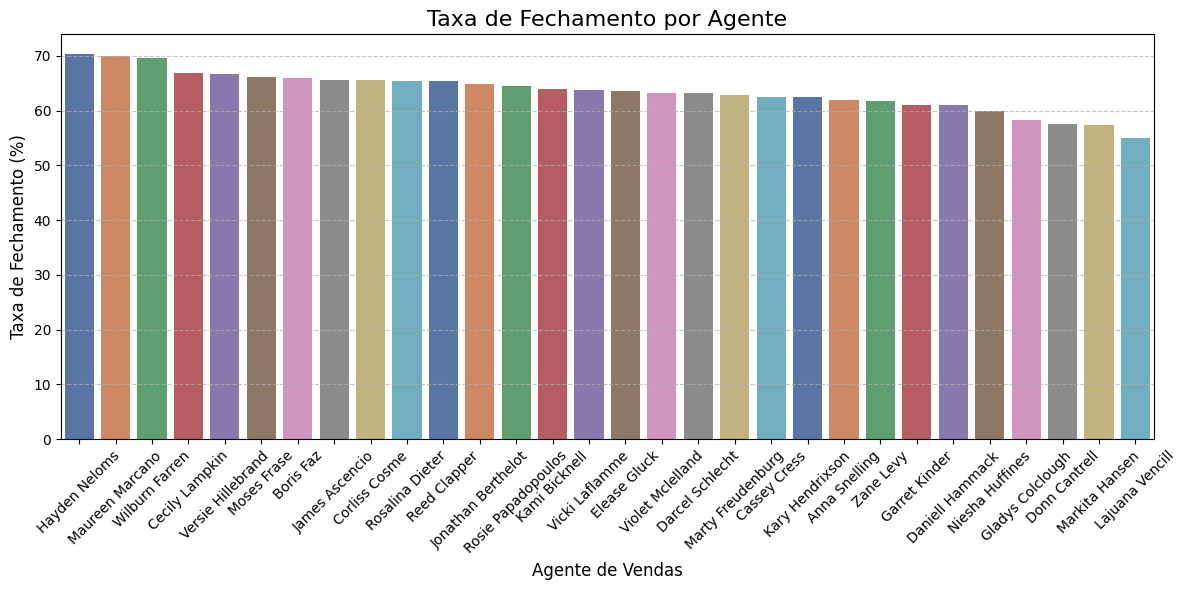

In [32]:
total_opportunities = engage_time_df.groupby('sales_agent')['opportunity_id'].count()
won_opportunities = engage_time_df[engage_time_df['deal_stage'] == 'Won'].groupby('sales_agent')['opportunity_id'].count()

close_rate = (won_opportunities / total_opportunities).fillna(0) * 100

plt.figure(figsize=(12, 6))

fee_per_agent_df = pd.DataFrame(close_rate.sort_values(ascending=False))
sns.barplot(x=fee_per_agent_df.index,
           y=fee_per_agent_df.columns[0], 
           data=fee_per_agent_df,
           palette='deep',
           legend=False)
plt.title('Taxa de Fechamento por Agente', fontsize=16)
plt.xlabel('Agente de Vendas', fontsize=12)
plt.ylabel('Taxa de Fechamento (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Receita Gerada por cada agente

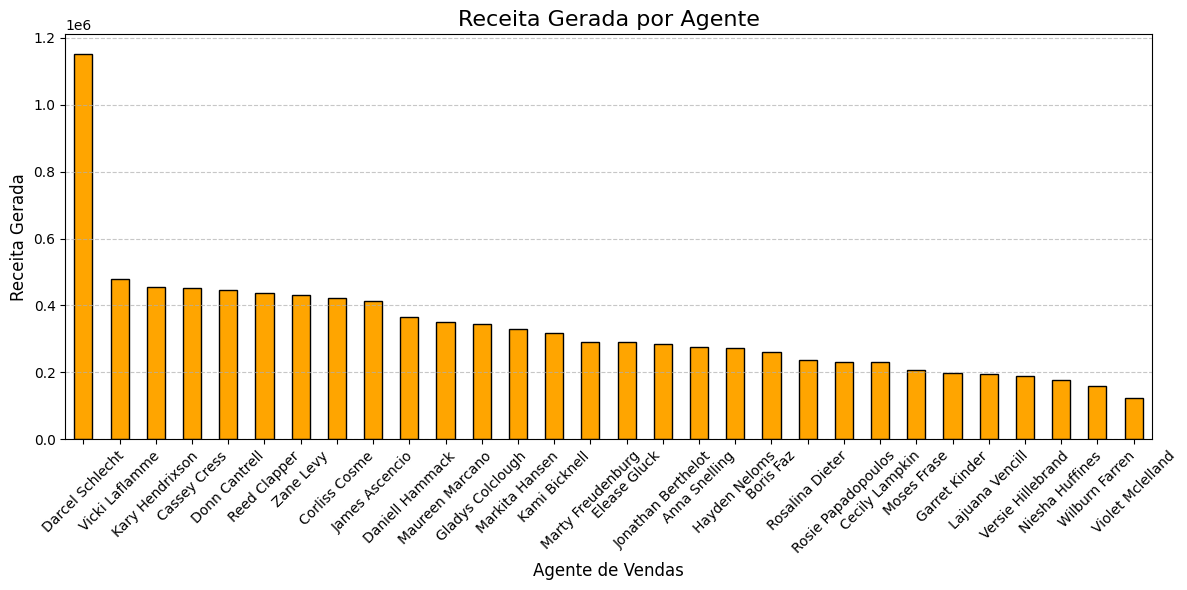

In [33]:
revenue_by_agent = engage_time_df.groupby('sales_agent')['close_value'].sum()

plt.figure(figsize=(12, 6))
revenue_by_agent.sort_values(ascending=False).plot(kind='bar', color='orange', edgecolor='black')

plt.title('Receita Gerada por Agente', fontsize=16)
plt.xlabel('Agente de Vendas', fontsize=12)
plt.ylabel('Receita Gerada', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Outlier closed value analysis by product

product
Gtx Basic           550
Gtx Pro            4821
Mg Special           55
Mg Advanced        3393
Gtx Plus Pro       5482
Gtx Plus Basic     1096
Gtk 500           26768
Name: sales_price, dtype: int64


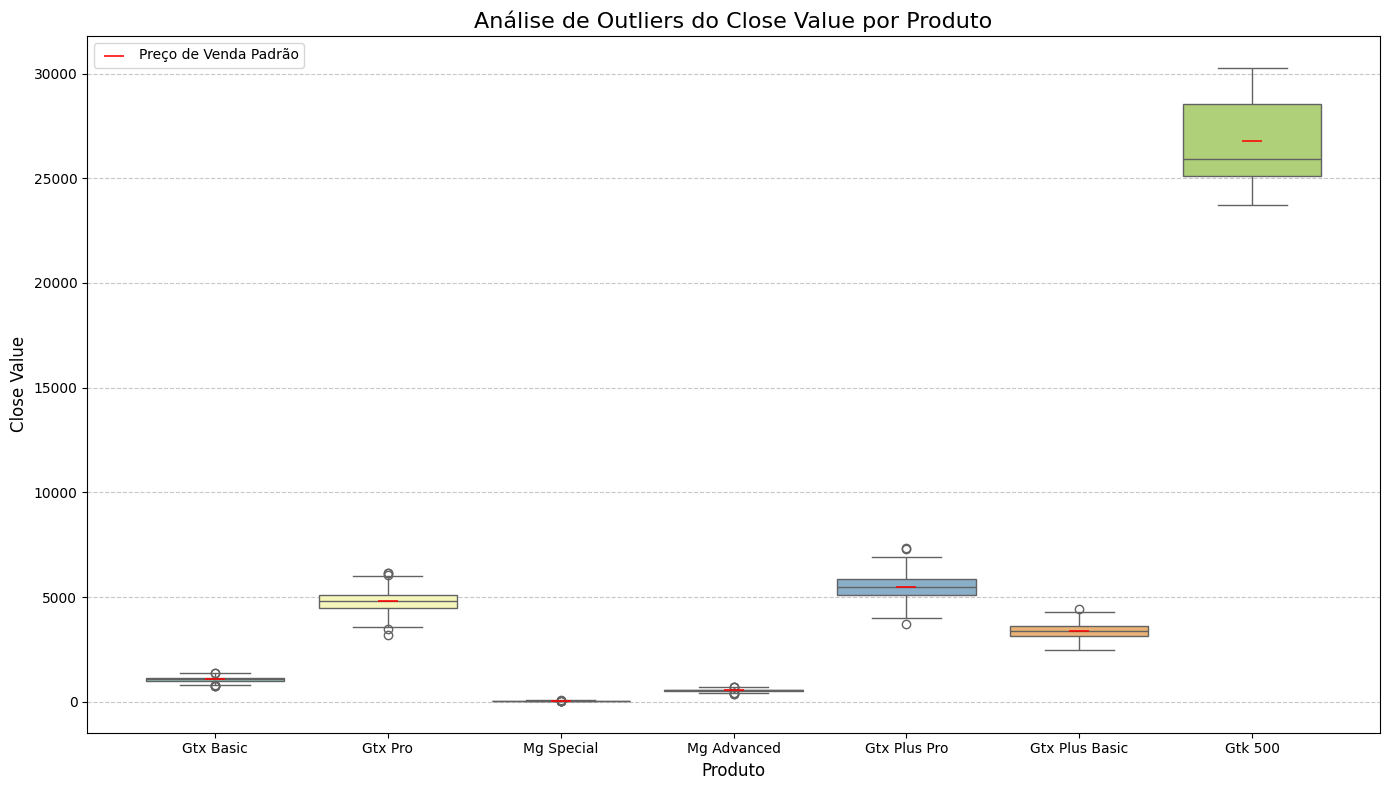

In [34]:
merged_df = pd.merge(engage_time_df[engage_time_df['deal_stage'] == 'Won'], products_df, on='product', how='inner')

outliers_summary = {}
for product, group in merged_df.groupby('product'):
    Q1 = group['close_value'].quantile(0.25)
    Q3 = group['close_value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['close_value'] < lower_bound) | (group['close_value'] > upper_bound)]
    outliers_summary[product] = {
        'Total Deals': len(group),
        'Outliers Count': len(outliers),
        'Outliers Percent': (len(outliers) / len(group)) * 100,
        'Outliers Details': outliers
    }

outliers_df = pd.DataFrame(outliers_summary).T
outliers_df.sort_values(by='Outliers Percent', ascending=False, inplace=True)

sales_prices = products_df.set_index('product')['sales_price']
merged_df['product'] = merged_df['product'].str.strip().str.title()
sales_prices.index = sales_prices.index.str.strip().str.title()

print(sales_prices)
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_df, x='product', y='close_value', palette='Set3', showfliers=True)
# sns.violinplot(data=merged_df, x='product', y='close_value', palette='Set3')
sns.scatterplot(x=sales_prices.index, y=sales_prices.values, color='red', marker='_', s=200, label='Preço de Venda Padrão', zorder=3)

plt.title('Análise de Outliers do Close Value por Produto', fontsize=16)
plt.xlabel('Produto', fontsize=12)
plt.ylabel('Close Value', fontsize=12)
plt.xticks(ticks=range(len(sales_prices)), labels=sales_prices.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can notice that Gtk 500 has a lower median price if compared with the default sales price based on winning prices

In [35]:
outliers_df

,Total Deals,Outliers Count,Outliers Percent,Outliers Details
GTX Plus Basic,653,6,0.918836,opportunity_id sales_agent p...
MG Special,793,7,0.882724,opportunity_id sales_agent pro...
GTX Basic,915,7,0.765027,opportunity_id sales_agent product...
GTX Pro,729,5,0.685871,opportunity_id sales_agent produ...
GTX Plus Pro,479,3,0.626305,opportunity_id sales_agent prod...
MG Advanced,654,1,0.152905,opportunity_id sales_agent produc...
GTK 500,15,0,0.0,"Empty DataFrame Columns: [opportunity_id, sale..."


## Customers analysis

In [36]:
accounts_df.columns

Index(['account', 'sector', 'year_established', 'revenue', 'employees',
       'office_location', 'subsidiary_of'],
      dtype='object')

In [37]:
accounts_df.head(10)

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
0,Acme Corporation,technolgy,1996,1100.04,2822,United States,NaN
1,Betasoloin,medical,1999,251.41,495,United States,NaN
2,Betatech,medical,1986,647.18,1185,Kenya,NaN
3,Bioholding,medical,2012,587.34,1356,Philipines,NaN
4,Bioplex,medical,1991,326.82,1016,United States,NaN
5,Blackzim,retail,2009,497.11,1588,United States,NaN
6,Bluth Company,technolgy,1993,1242.32,3027,United States,Acme Corporation
7,Bubba Gump,software,2002,987.39,2253,United States,NaN
8,Cancity,retail,2001,718.62,2448,United States,NaN
9,Cheers,entertainment,1993,4269.90,6472,United States,Massive Dynamic


In [38]:
accounts_df.sector.value_counts()

sector
retail                17
technolgy             12
medical               12
marketing              8
finance                8
software               7
entertainment          6
telecommunications     6
services               5
employment             4
Name: count, dtype: int64

### Revenue by sector

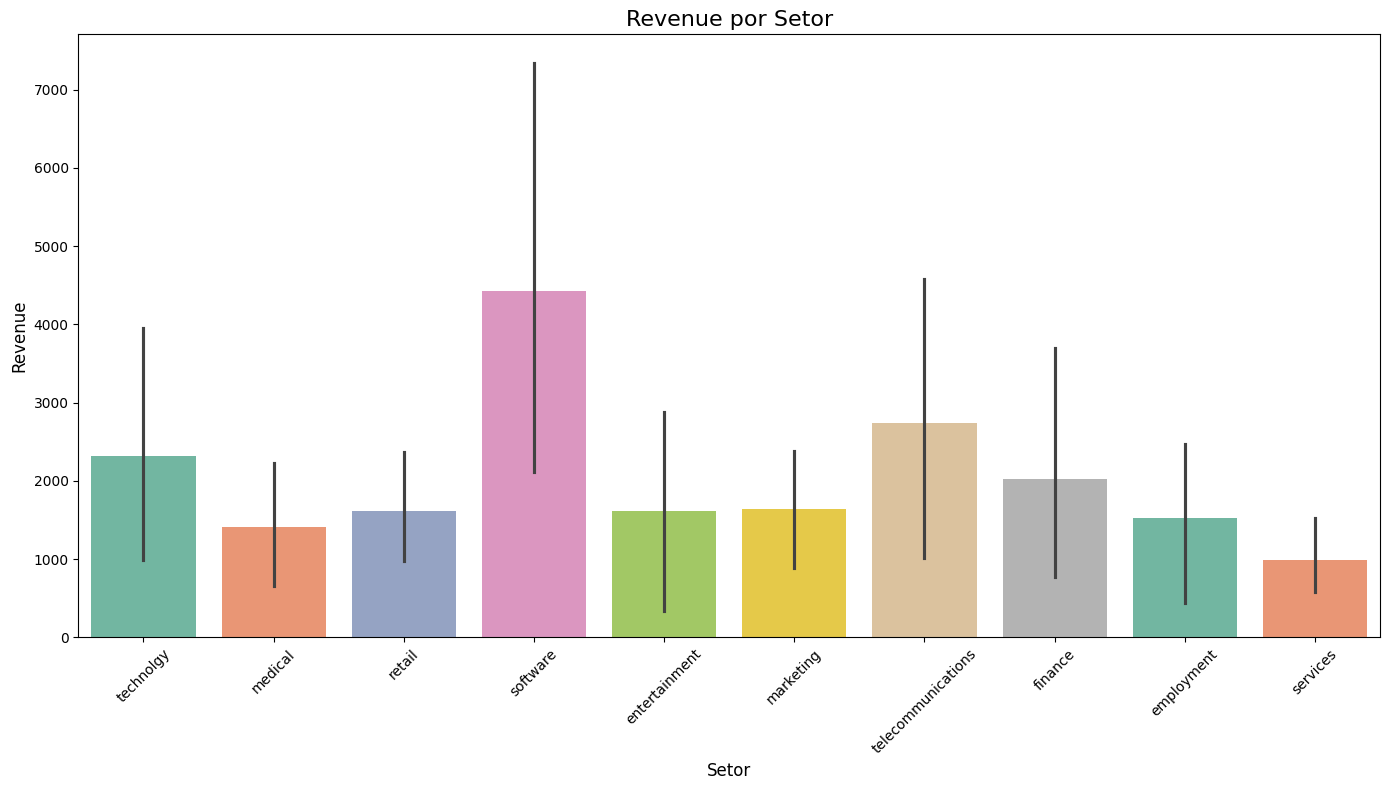

In [39]:
plt.figure(figsize=(14, 8))
sns.barplot(data=accounts_df, x='sector', y='revenue', palette='Set2')
plt.title('Revenue por Setor', fontsize=16)
plt.xlabel('Setor', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

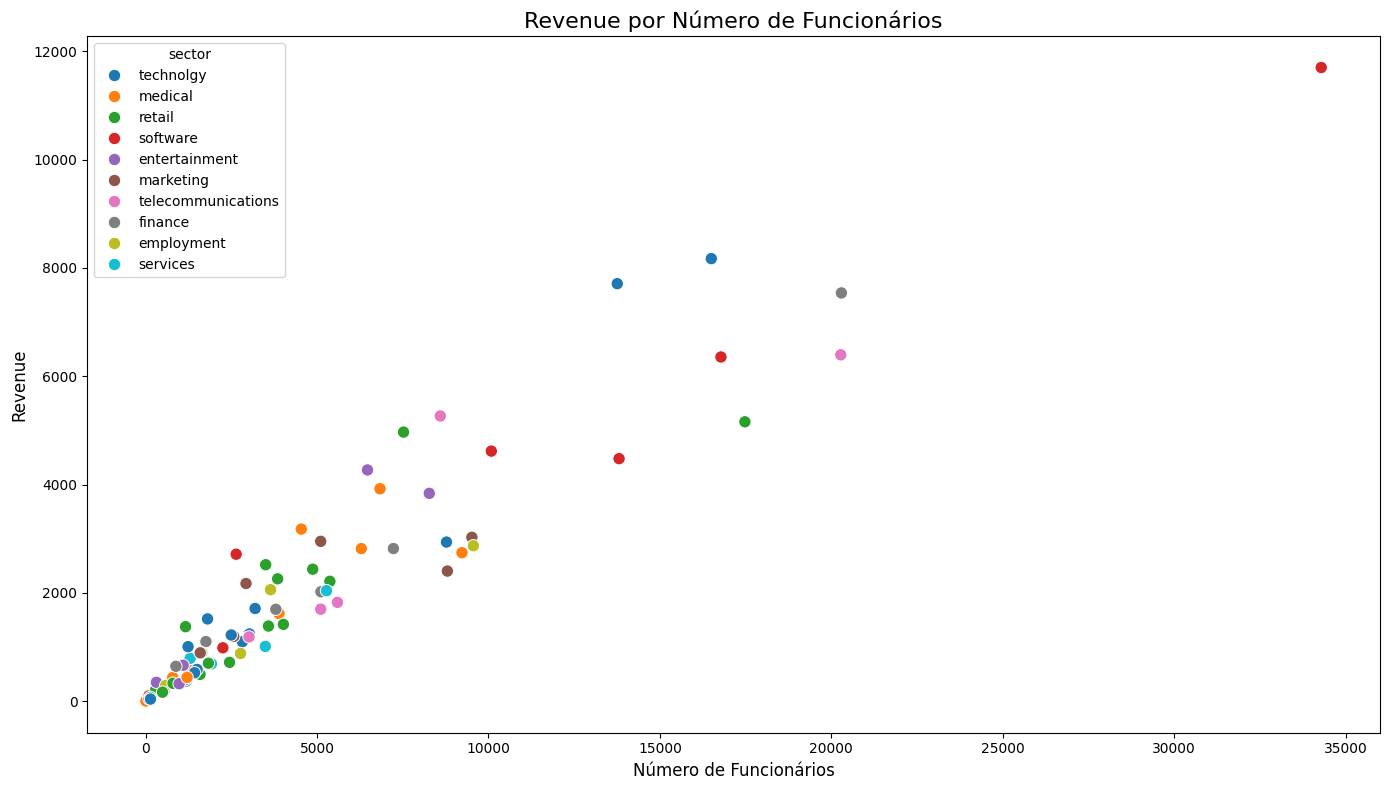

In [40]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=accounts_df, x='employees', y='revenue', color='blue', s=80, hue='sector')
plt.title('Revenue por Número de Funcionários', fontsize=16)
plt.xlabel('Número de Funcionários', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.tight_layout()
plt.show()

### Deal Stages distribution

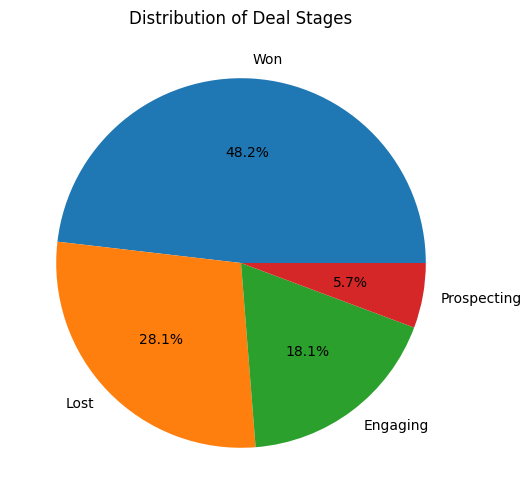

In [41]:
plt.figure(figsize=(10, 6))
sales_pipeline_df['deal_stage'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Deal Stages')
plt.ylabel('')
plt.show()

## Sales Team analysis...

In [42]:
sales_teams_df

,sales_agent,manager,regional_office
0,Anna Snelling,Dustin Brinkmann,Central
1,Cecily Lampkin,Dustin Brinkmann,Central
2,Versie Hillebrand,Dustin Brinkmann,Central
3,Lajuana Vencill,Dustin Brinkmann,Central
4,Moses Frase,Dustin Brinkmann,Central
5,Jonathan Berthelot,Melvin Marxen,Central
6,Marty Freudenburg,Melvin Marxen,Central
7,Gladys Colclough,Melvin Marxen,Central
8,Niesha Huffines,Melvin Marxen,Central
9,Darcel Schlecht,Melvin Marxen,Central


## Getting all together

In [43]:
print('Sales pipeline columns: ', sales_pipeline_df.columns)
print('Accounts columns: ', accounts_df.columns)
print('Products columns: ', products_df.columns)
print('Sales teams columns: ', sales_teams_df.columns)

Sales pipeline columns:  Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_date', 'close_date', 'close_value'],
      dtype='object')
Accounts columns:  Index(['account', 'sector', 'year_established', 'revenue', 'employees',
       'office_location', 'subsidiary_of'],
      dtype='object')
Products columns:  Index(['product', 'series', 'sales_price'], dtype='object')
Sales teams columns:  Index(['sales_agent', 'manager', 'regional_office'], dtype='object')


In [44]:
df = (pd.merge(
                pd.merge(
                    pd.merge(sales_pipeline_df, accounts_df, on='account', how='inner'),
                    products_df, on='product', how='inner'),
                sales_teams_df, on='sales_agent', how='inner'))

df

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001,718.62,2448,United States,NaN,GTX,1096,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002,3178.24,4540,United States,NaN,GTX,4821,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001,718.62,2448,United States,NaN,MG,55,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998,2714.90,2641,United States,Acme Corporation,GTX,550,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982,792.46,1299,United States,NaN,GTX,550,Summer Sewald,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,VW8CEV4C,Versie Hillebrand,MG Special,Konmatfix,Prospecting,NaN,NaN,NaN,marketing,1985,375.43,1190,United States,NaN,MG,55,Dustin Brinkmann,Central
7371,KLUS7RVS,Versie Hillebrand,MG Special,Opentech,Prospecting,NaN,NaN,NaN,finance,1994,355.23,853,United States,NaN,MG,55,Dustin Brinkmann,Central
7372,ROM4I2T0,Versie Hillebrand,MG Special,Rundofase,Prospecting,NaN,NaN,NaN,technolgy,1983,1008.06,1238,United States,NaN,MG,55,Dustin Brinkmann,Central
7373,FCNN6UY0,Versie Hillebrand,MG Advanced,Ganjaflex,Prospecting,NaN,NaN,NaN,retail,1995,5158.71,17479,Japan,NaN,MG,3393,Dustin Brinkmann,Central


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7375 entries, 0 to 7374
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    7375 non-null   object 
 1   sales_agent       7375 non-null   object 
 2   product           7375 non-null   object 
 3   account           7375 non-null   object 
 4   deal_stage        7375 non-null   object 
 5   engage_date       7212 non-null   object 
 6   close_date        6711 non-null   object 
 7   close_value       6711 non-null   float64
 8   sector            7375 non-null   object 
 9   year_established  7375 non-null   int64  
 10  revenue           7375 non-null   float64
 11  employees         7375 non-null   int64  
 12  office_location   7375 non-null   object 
 13  subsidiary_of     1292 non-null   object 
 14  series            7375 non-null   object 
 15  sales_price       7375 non-null   int64  
 16  manager           7375 non-null   object 


## Feature Engenieering

In [46]:
df['engage_date'] = pd.to_datetime(df['engage_date'])
df['close_date'] = pd.to_datetime(df['close_date'])
df['year_established'] = df['year_established'].astype(str)

df['sales_cycle_duration'] = (df['close_date'] - df['engage_date']).dt.days
df['agent_close_rate'] = df['sales_agent'].map(close_rate)
df['opportunities_per_account'] = df.groupby('account')['opportunity_id'].transform('count')
df['opportunities_per_sales_agent'] = df.groupby('sales_agent')['opportunity_id'].transform('count')

In [47]:
df

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,...,office_location,subsidiary_of,series,sales_price,manager,regional_office,sales_cycle_duration,agent_close_rate,opportunities_per_account,opportunities_per_sales_agent
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001,...,United States,NaN,GTX,1096,Dustin Brinkmann,Central,132.0,66.153846,101,216
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002,...,United States,NaN,GTX,4821,Melvin Marxen,Central,137.0,63.110307,119,613
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001,...,United States,NaN,MG,55,Melvin Marxen,Central,133.0,63.110307,101,613
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998,...,United States,Acme Corporation,GTX,550,Dustin Brinkmann,Central,135.0,66.153846,121,216
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982,...,United States,NaN,GTX,550,Summer Sewald,West,128.0,61.685824,87,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,VW8CEV4C,Versie Hillebrand,MG Special,Konmatfix,Prospecting,NaT,NaT,NaN,marketing,1985,...,United States,NaN,MG,55,Dustin Brinkmann,Central,NaN,66.666667,74,292
7371,KLUS7RVS,Versie Hillebrand,MG Special,Opentech,Prospecting,NaT,NaT,NaN,finance,1994,...,United States,NaN,MG,55,Dustin Brinkmann,Central,NaN,66.666667,60,292
7372,ROM4I2T0,Versie Hillebrand,MG Special,Rundofase,Prospecting,NaT,NaT,NaN,technolgy,1983,...,United States,NaN,MG,55,Dustin Brinkmann,Central,NaN,66.666667,104,292
7373,FCNN6UY0,Versie Hillebrand,MG Advanced,Ganjaflex,Prospecting,NaT,NaT,NaN,retail,1995,...,Japan,NaN,MG,3393,Dustin Brinkmann,Central,NaN,66.666667,81,292


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7375 entries, 0 to 7374
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   opportunity_id                 7375 non-null   object        
 1   sales_agent                    7375 non-null   object        
 2   product                        7375 non-null   object        
 3   account                        7375 non-null   object        
 4   deal_stage                     7375 non-null   object        
 5   engage_date                    7212 non-null   datetime64[ns]
 6   close_date                     6711 non-null   datetime64[ns]
 7   close_value                    6711 non-null   float64       
 8   sector                         7375 non-null   object        
 9   year_established               7375 non-null   object        
 10  revenue                        7375 non-null   float64       
 11  employees        

# Model Training

### Filtering the target variable

In [49]:
df['deal_stage'].value_counts()

deal_stage
Won            4238
Lost           2473
Engaging        501
Prospecting     163
Name: count, dtype: int64

In [50]:
df = df[df['deal_stage'].isin(['Won', 'Lost'])]
df['deal_stage'].value_counts()

deal_stage
Won     4238
Lost    2473
Name: count, dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6711 entries, 0 to 7211
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   opportunity_id                 6711 non-null   object        
 1   sales_agent                    6711 non-null   object        
 2   product                        6711 non-null   object        
 3   account                        6711 non-null   object        
 4   deal_stage                     6711 non-null   object        
 5   engage_date                    6711 non-null   datetime64[ns]
 6   close_date                     6711 non-null   datetime64[ns]
 7   close_value                    6711 non-null   float64       
 8   sector                         6711 non-null   object        
 9   year_established               6711 non-null   object        
 10  revenue                        6711 non-null   float64       
 11  employees             

Just 'subsidiary_of' variable with missing values

## Train test split

In [52]:
X = df.drop(['opportunity_id', 'deal_stage', 'close_value', 'engage_date', 'close_date'], axis=1)
y = df['deal_stage'].map({'Won': 1, 'Lost': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6711 entries, 0 to 7211
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sales_agent                    6711 non-null   object 
 1   product                        6711 non-null   object 
 2   account                        6711 non-null   object 
 3   sector                         6711 non-null   object 
 4   year_established               6711 non-null   object 
 5   revenue                        6711 non-null   float64
 6   employees                      6711 non-null   int64  
 7   office_location                6711 non-null   object 
 8   subsidiary_of                  1160 non-null   object 
 9   series                         6711 non-null   object 
 10  sales_price                    6711 non-null   int64  
 11  manager                        6711 non-null   object 
 12  regional_office                6711 non-null   object

In [54]:
numeric_features = [
    'sales_cycle_duration',
    'revenue', 
    'employees',
    'sales_price',
    'sales_cycle_duration',
    'agent_close_rate',
    'opportunities_per_account',
    'opportunities_per_sales_agent'
]

categorical_features = [
    'sales_agent',
    'product',
    'sector',
    'office_location',
    'series',
    'manager',
    'regional_office',
    'year_established']

# Pré-processadores
numeric_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

# Combinando transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [55]:
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
weights_dict = dict(zip(classes, class_weights))

In [56]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

In [57]:
models = {
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=321, class_weight='balanced'),
    'XGBoost': SklearnXGBClassifier(objective='binary:logistic'),
    # 'SVM': SVC(probability=True, random_state=321, class_weight='balanced'),
    # 'Naive Bayes': GaussianNB(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=321, class_weight='balanced'),
#     'AdaBoost': AdaBoostClassifier(random_state=321, class_weight='balanced'),
#     'LightGBM': LGBMClassifier(random_state=321, class_weight='balanced'),
#     'CatBoost': CatBoostClassifier(random_state=321, verbose=0, class_weight='balanced')
}

def run_models_pipeline(preprocessor, scaler, model, X, y):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('classifier', model)
    ])

    stratified_kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(pipeline, X, y, cv=stratified_kfold, scoring='accuracy')

    return [scores.mean(), pipeline]

In [58]:
np.unique(y, return_counts=True)

(array([0, 1]), array([2473, 4238]))

In [59]:
all_scores = {}

for name, model in models.items():
    score_and_pipeline = run_models_pipeline(preprocessor,
                                             StandardScaler(with_mean=False),
                                             model, X, y)

    all_scores[name] = score_and_pipeline
    print(f"{name} Mean Recall: {score_and_pipeline[0]}")

XGBoost Mean Recall: 0.5952912546482118
Random Forest Mean Recall: 0.6161533058204324


In [60]:
best_score = max(list(all_scores.items()), key=lambda x: x[1])
best_model = best_score[0]
print(f"Best Model:", best_model)

Best Model: Random Forest


# RFM Analysis

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

RFM factors illustrate these facts:

- The more recent the purchase, the more responsive the customer is to promotions
- The more frequently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders from low-value purchasers

A good segmentation of customers can lead to a more efective marketing guidance for the company.

If the focus is on optimizing retention and maximizing the value of existing customers, RFM analysis with only “won” customers is more appropriate. If the goal is to understand the sales process and explore opportunities to win back lost customers, including “lost” customers in the RFM analysis can provide valuable insights into their behavior, helping to improve the sales funnel and recovery strategies.

OBS: This specific RFM analysis was only aplied to customers that the `deal_stage` is `Won`. It can be aplied to `Lost` deal stages, but we will focous only on `Won` deal stages for now.

In [61]:
df.close_date.max()

Timestamp('2017-12-31 00:00:00')

In [62]:
df_won = df[df['deal_stage'] == 'Won']

Junuary 1st of 2018 is the reference day for recency calculation

In [63]:
from datetime import datetime, timedelta

today_date = datetime(2018,1,1)

In [64]:
rfm = df_won.groupby('account').agg({
    'close_date': ['min', 'max', lambda x: (today_date - x.max()).days],
    'account': 'count',
    'close_value': 'sum',
    'office_location': 'first',
    'product': 'first',
    'revenue': 'first',
})
rfm = rfm.reset_index()
rfm.columns = ['account', 'first_purchase', 'last_purchase', 'Recency', 'Frequency', 'Monetary', 'office_location', 'product', 'revenue']

rfm.head()

,account,first_purchase,last_purchase,Recency,Frequency,Monetary,office_location,product,revenue
0,Acme Corporation,2017-03-01,2017-12-27,5,34,101744.0,United States,GTX Basic,1100.04
1,Betasoloin,2017-03-01,2017-12-28,4,34,97036.0,United States,GTX Plus Pro,251.41
2,Betatech,2017-03-08,2017-12-29,3,53,107408.0,Kenya,GTX Plus Pro,647.18
3,Bioholding,2017-03-10,2017-12-28,4,50,90991.0,Philipines,MG Special,587.34
4,Bioplex,2017-03-04,2017-12-16,16,31,67393.0,United States,MG Special,326.82


In [65]:
rfm.Monetary.value_counts()

Monetary
163339.0    2
101744.0    1
107408.0    1
97036.0     1
67393.0     1
           ..
86690.0     1
76684.0     1
138339.0    1
78237.0     1
116394.0    1
Name: count, Length: 84, dtype: int64

Using `pd.cut` to get intervals of same size

In [66]:
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm

,account,first_purchase,last_purchase,Recency,Frequency,Monetary,office_location,product,revenue,R_Score,F_Score,M_Score,RFM_Score
0,Acme Corporation,2017-03-01,2017-12-27,5,34,101744.0,United States,GTX Basic,1100.04,4,1,1,411
1,Betasoloin,2017-03-01,2017-12-28,4,34,97036.0,United States,GTX Plus Pro,251.41,4,1,1,411
2,Betatech,2017-03-08,2017-12-29,3,53,107408.0,Kenya,GTX Plus Pro,647.18,4,2,1,421
3,Bioholding,2017-03-10,2017-12-28,4,50,90991.0,Philipines,MG Special,587.34,4,2,1,421
4,Bioplex,2017-03-04,2017-12-16,16,31,67393.0,United States,MG Special,326.82,3,1,1,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Zencorporation,2017-03-12,2017-12-18,14,33,86690.0,China,GTX Basic,40.79,3,1,1,311
81,Zoomit,2017-03-09,2017-12-28,4,33,76684.0,United States,GTX Basic,324.19,4,1,1,411
82,Zotware,2017-03-15,2017-12-30,2,47,138339.0,United States,MG Advanced,4478.47,4,2,2,422
83,Zumgoity,2017-03-02,2017-12-27,5,36,78237.0,United States,GTX Plus Basic,441.08,4,1,1,411


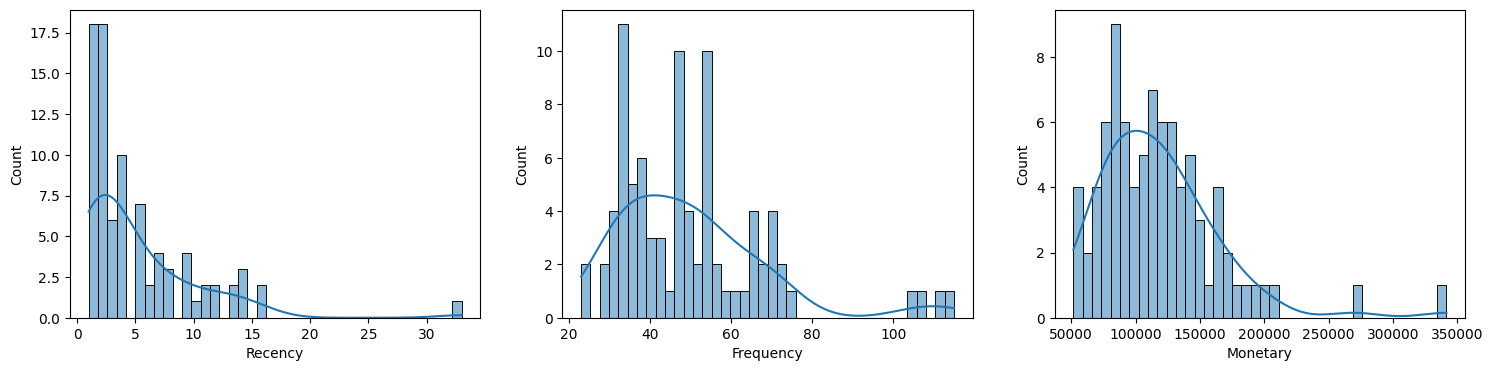

In [67]:
cols = ['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

for i, col in enumerate(cols):
    sns.histplot(data=rfm, x=col, kde=True, bins=40, ax=axes[i])

plt.show()

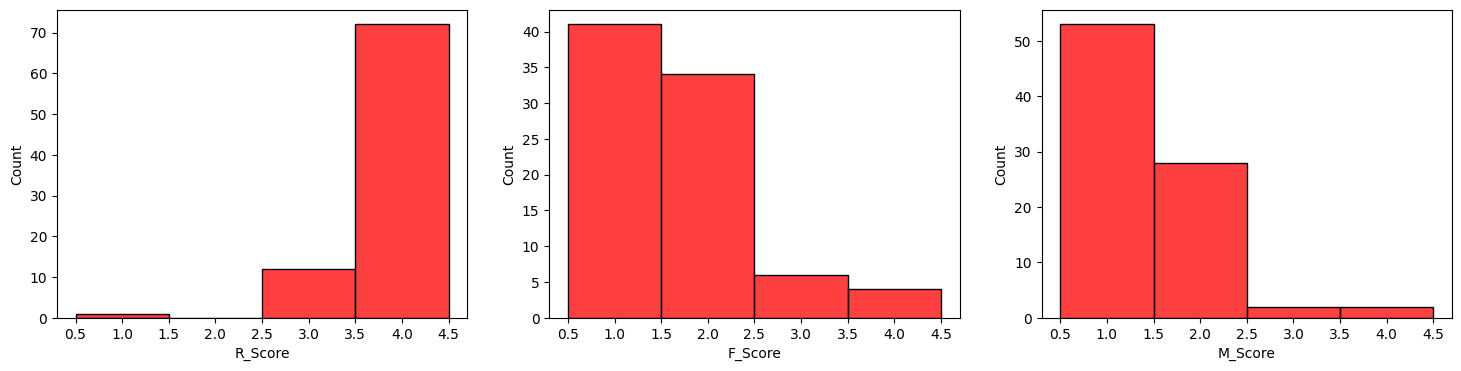

In [68]:
cols = ['R_Score', 'F_Score', 'M_Score']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

for i, col in enumerate(cols):
    sns.histplot(data=rfm, x=col, ax=axes[i], color='red')

plt.show()

### Clustering evaluation function

In [69]:
def ratio_info(df, col_name):
    ratio_df = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    
    ratio_df

    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df,
                       x=col_name,
                       palette = 'Set3')

    total = len(df[col_name])

    for patch in ax.patches:
        percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
        x = patch.get_x() + patch.get_width() / 2 - 0.17
        y = patch.get_y() + patch.get_height() * 1.005
        ax.annotate(percentage, (x, y), size = 14)

    plt.title('Number of Customers by Segments', size = 16)
    plt.xlabel('Segment', size = 14)
    plt.ylabel('Count', size = 14)
    plt.xticks(rotation=30)
    plt.xticks(size = 10)
    plt.yticks(size = 10)
    plt.show()

## K-means Clustering RFM analysis for customers segmentations

Disavantages: ambiguous result of clusters, so the decision maker would not have a real ideia of why the custumers are segmented this way. But overwall, it can be a good solution of semetation

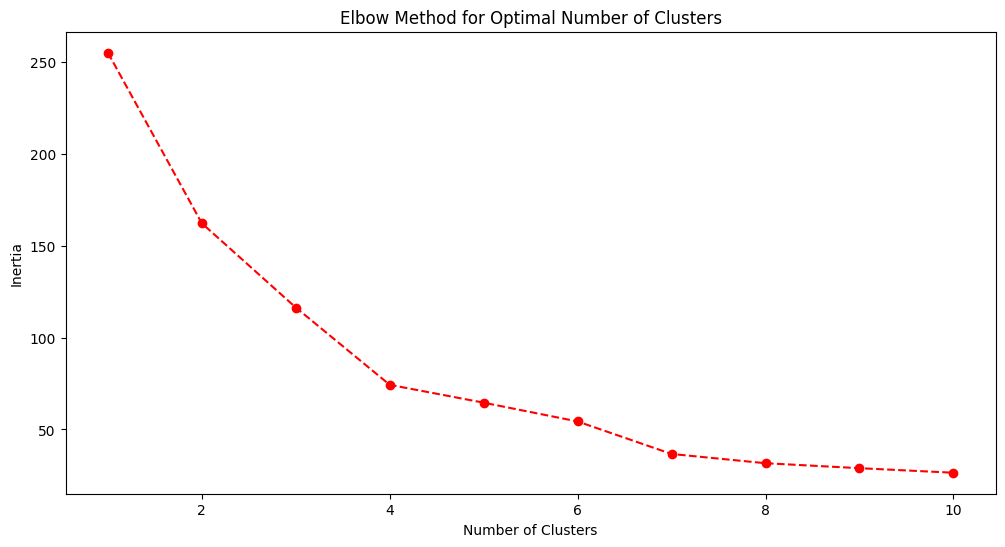

In [70]:
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range_clusters, inertia, marker='o', linestyle='--', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

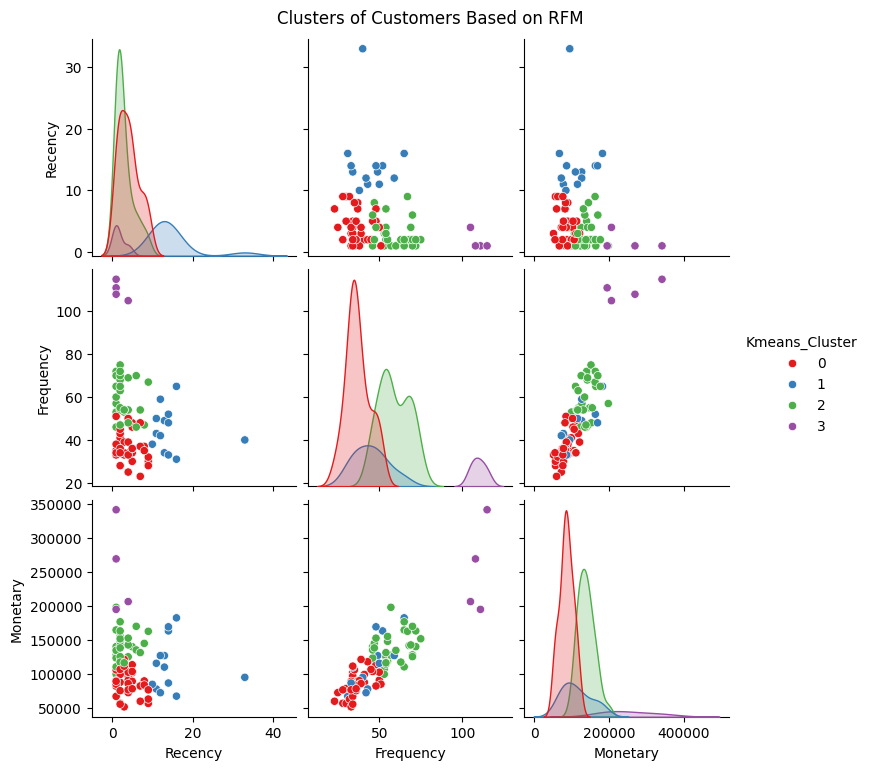


Centroids of the clusters in original scale:


,Recency,Frequency,Monetary
0,4.083333,36.916667,85823.777778
1,14.538462,44.923077,113798.230769
2,2.906250,58.937500,138263.562500
3,1.750000,109.750000,253016.750000


In [71]:
optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Kmeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Kmeans_Cluster', palette='Set1')
plt.suptitle('Clusters of Customers Based on RFM', y=1.02)
plt.show()

centroids = kmeans.cluster_centers_

centroids_original = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_original, columns=['Recency', 'Frequency', 'Monetary'])
print()
print("Centroids of the clusters in original scale:")
centroids_df

### Metrics and Results

In [72]:
rfm.groupby("Kmeans_Cluster").agg({"Recency": ["count", "mean"],
                            "Frequency": ["count", "mean"],
                            "Monetary": ["count", "mean"]})

Recency            Frequency             Monetary  \
                 count       mean     count        mean    count   
Kmeans_Cluster                                                     
0                   36   4.083333        36   36.916667       36   
1                   13  14.538462        13   44.923077       13   
2                   32   2.906250        32   58.937500       32   
3                    4   1.750000         4  109.750000        4   

                               
                         mean  
Kmeans_Cluster                 
0                85823.777778  
1               113798.230769  
2               138263.562500  
3               253016.750000

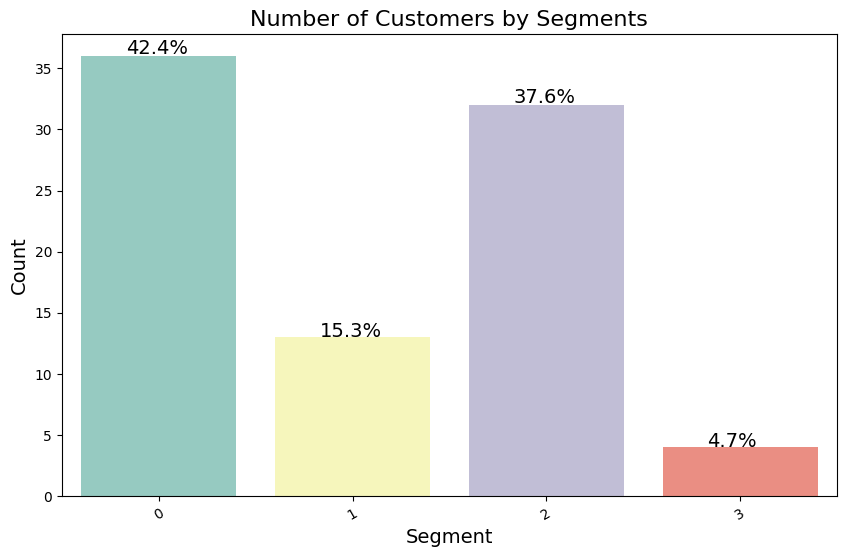

In [73]:
ratio_info(rfm, "Kmeans_Cluster")

In [74]:
print('K-Means RFM Model Evaluation '.center(70, '='))
X = rfm[['Recency', 'Frequency', 'Monetary']]
labels = rfm['Kmeans_Cluster']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

====================K-Means RFM Model Evaluation =====================
Number of Observations: 85
Number of Segments: 4
Silhouette Score: 0.239
Calinski Harabasz Score: 57.241
Davies Bouldin Score: 1.551 


## Agglomerative Clustering RFM analysis for customers segmentation

Choosing a method for calulate the distances between clusters at the merging stage (`Z`):

- `ward`: If your goal is to create compact, homogeneous clusters, ward method is usually the best choice.
- `complete`: If you want to avoid large clusters, complete method may be more suitable, although it can generate more dispersed clusters.
- `single`: If your data has a clear hierarchical structures and search for connected clusters.
- `average`: Is a intermediate choice, balancing the formation of compact and dispersed clusters.

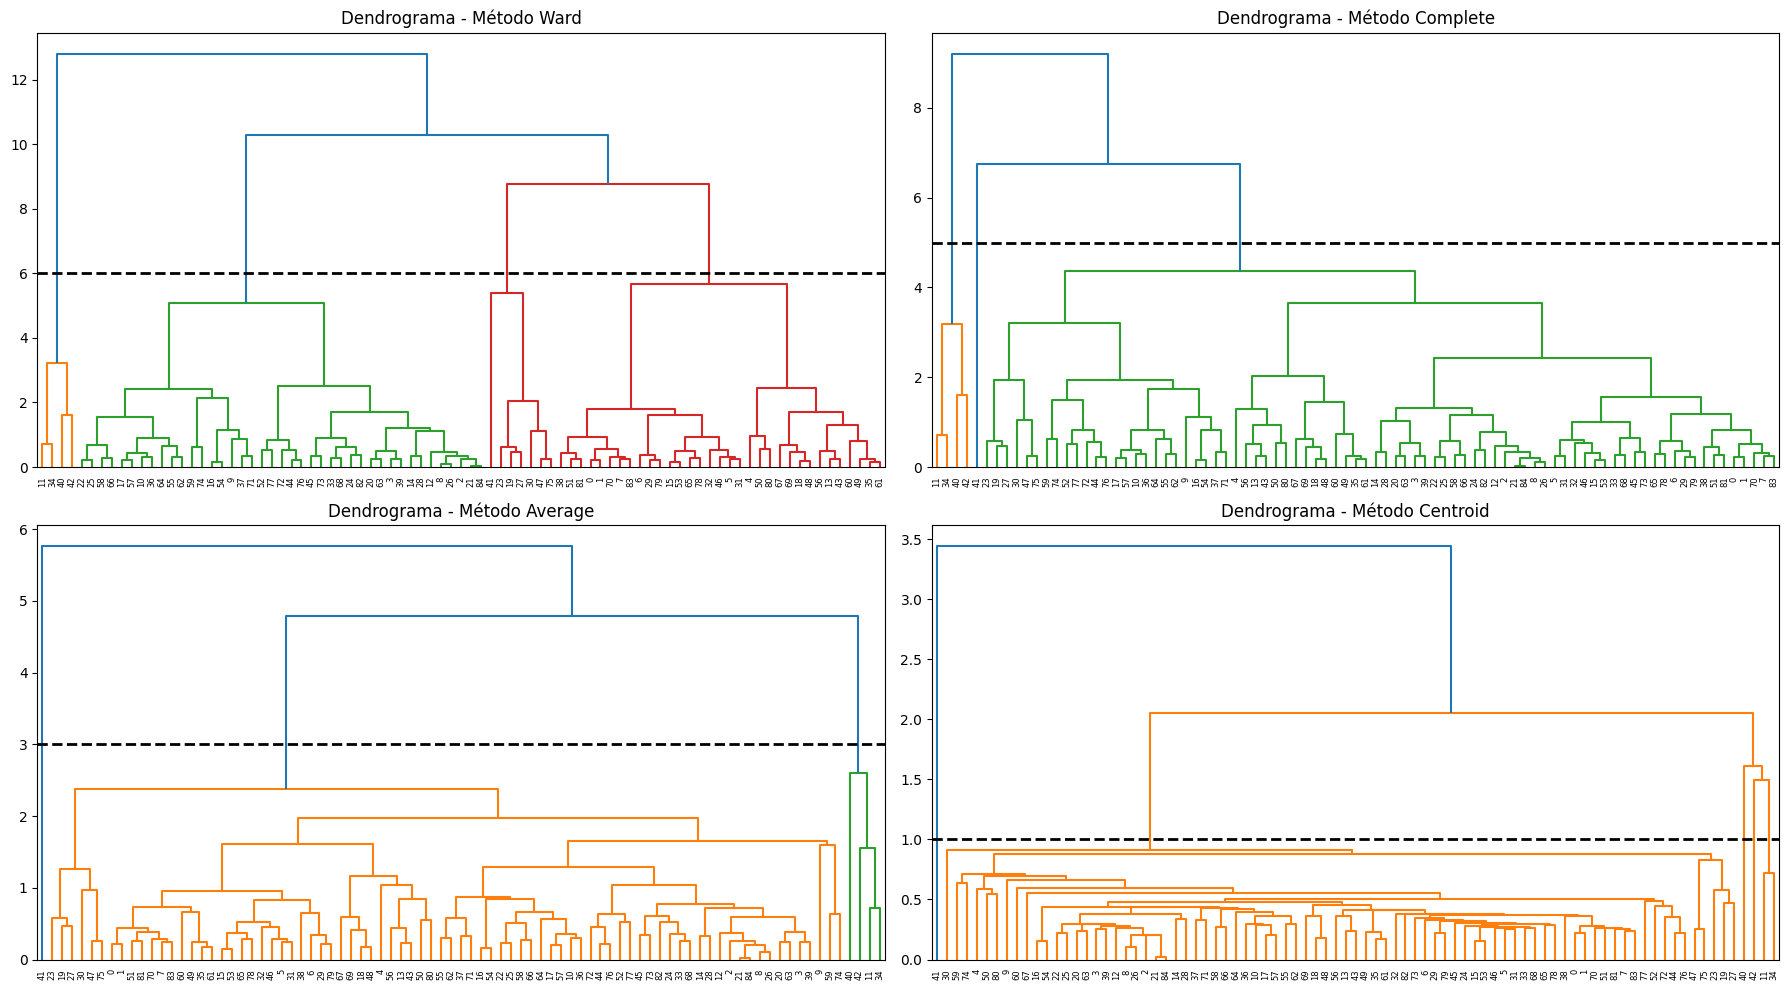

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

Z_ward = linkage(rfm_scaled, method='ward')
dendrogram(Z_ward, ax=axes[0, 0])
axes[0, 0].set_title("Dendrograma - Método Ward")
axes[0, 0].axhline(y=6, color='black', linestyle='--', linewidth=2)

Z_complete = linkage(rfm_scaled, method='complete')
dendrogram(Z_complete, ax=axes[0, 1])
axes[0, 1].set_title("Dendrograma - Método Complete")
axes[0, 1].axhline(y=5, color='black', linestyle='--', linewidth=2)

Z_average = linkage(rfm_scaled, method='average')
dendrogram(Z_average, ax=axes[1, 0])
axes[1, 0].set_title("Dendrograma - Método Average")
axes[1, 0].axhline(y=3, color='black', linestyle='--', linewidth=2)

Z_centroid = linkage(rfm_scaled, method='single')
dendrogram(Z_centroid, ax=axes[1, 1])
axes[1, 1].set_title("Dendrograma - Método Centroid")
axes[1, 1].axhline(y=1, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

The important thing to note is when an abrupt increase in the distance (Euclidean distance) between the clusters occour. This increase, indicates that the clusters are moving apart more significantly, which generally indicates that the separation between the groups is clearer. This specificy behavior begins with a Eucliadian Distance of:
- 6, if we look at the dendogram of the `ward` method.
- 5, if we look at the dendogram of the `complete` method.
- 3, if we look at the dendogram of the `average` method.
- 1, if we look at the dendogram of the `single` method.

Ward's method is often preferred due to its focus on minimizing within-cluster variance. This approach typically leads to more compact and spherical clusters, making it suitable for data with a natural clustering structure. By minimizing the increase in variance at each merge step, Ward's method tends to produce clusters that are internally homogeneous and well-separated, even in the presence of some noise or outliers. This makes it a robust choice in our case (Customer segmentation).

In [76]:
clusters = fcluster(Z_ward, t=6, criterion='distance')

num_clusters = len(np.unique(clusters))
num_clusters

4

A Euclidian distance of 3 generates 3 clusters

In [77]:
model = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward")
rfm['Agg_Cluster'] = model.fit_predict(rfm_scaled)

### Metrics and Results

In [78]:
rfm.groupby("Agg_Cluster").agg({"Recency": ["count", "mean"],
                            "Frequency": ["count", "mean"],
                            "Monetary": ["count", "mean"]})

Recency            Frequency             Monetary               
              count       mean     count        mean    count           mean
Agg_Cluster                                                                 
0                33   5.878788        33   34.666667       33   79862.393939
1                 7  16.142857         7   51.857143        7  140007.000000
2                41   2.975610        41   55.902439       41  131169.731707
3                 4   1.750000         4  109.750000        4  253016.750000

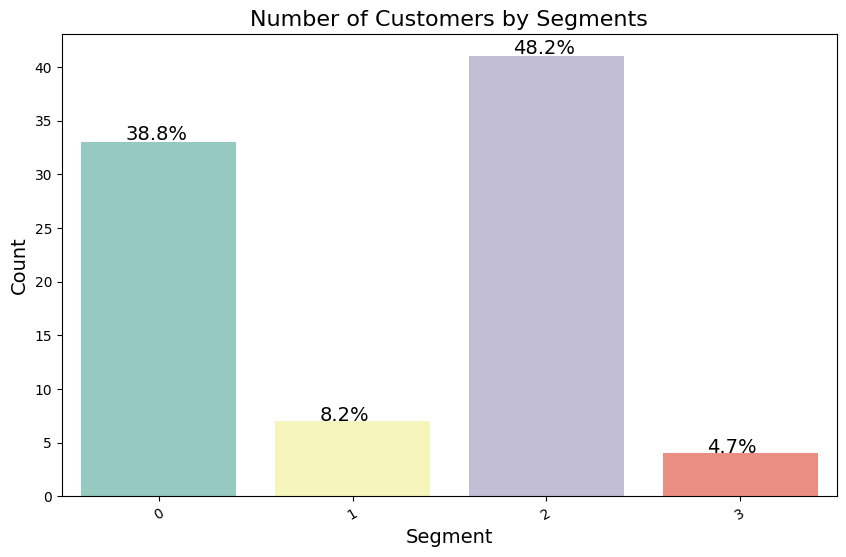

In [79]:
ratio_info(rfm, "Agg_Cluster")

In [80]:
print('Agglomerative Clustering RFM Model Evaluation '.center(70, '='))
X = rfm[['Recency', 'Frequency', 'Monetary']]
labels = rfm['Agg_Cluster']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

============Agglomerative Clustering RFM Model Evaluation ============
Number of Observations: 85
Number of Segments: 4
Silhouette Score: 0.264
Calinski Harabasz Score: 70.371
Davies Bouldin Score: 2.982 


## HDBSCAN Clustering with UMAP for RFM analysis of customers segmentation

/home/diogo/Documentos/Projetos/ai_analysis_crm/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



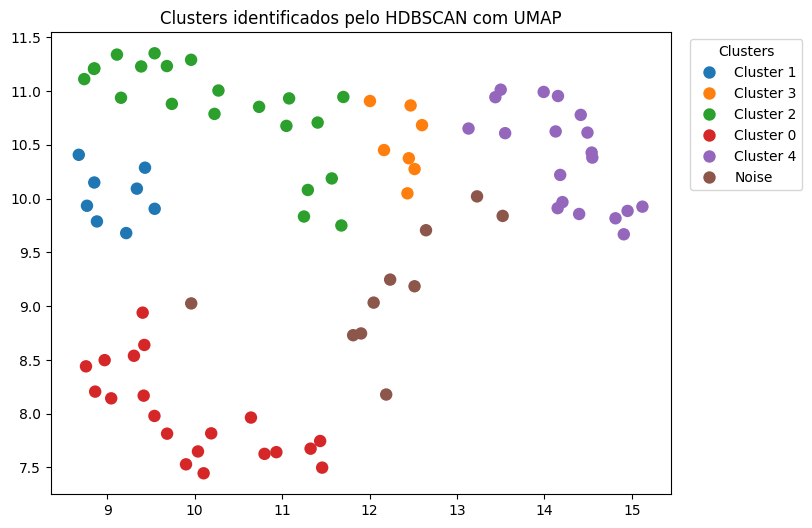

In [81]:
from sklearn.cluster import HDBSCAN
import umap

reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(rfm_scaled)
clusterer = HDBSCAN(min_cluster_size=5, min_samples=4)
labels = clusterer.fit_predict(embedding)
u, counts = np.unique(labels, return_counts=True)

rfm['HDBSCAN_Cluster'] = [f"Cluster {label}" if label != -1 else "Noise" for label in labels]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=rfm['HDBSCAN_Cluster'],
    palette='tab10',
    s=80, 
    edgecolor='none'
)
plt.title('Clusters identificados pelo HDBSCAN com UMAP')
plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

### Metrics and Results

In [82]:
rfm.groupby("HDBSCAN_Cluster").agg({"Recency": ["count", "mean"],
                            "Frequency": ["count", "mean"],
                            "Monetary": ["count", "mean"]})

Recency            Frequency            Monetary  \
                  count       mean     count       mean    count   
HDBSCAN_Cluster                                                    
Cluster 0            20  12.300000        20  40.300000       20   
Cluster 1             8   4.500000         8  33.375000        8   
Cluster 2            21   2.285714        21  39.904762       21   
Cluster 3             7   2.571429         7  53.857143        7   
Cluster 4            19   1.894737        19  75.631579       19   
Noise                10   5.200000        10  51.300000       10   

                                
                          mean  
HDBSCAN_Cluster                 
Cluster 0         99594.400000  
Cluster 1         85007.875000  
Cluster 2         92296.571429  
Cluster 3        114140.714286  
Cluster 4        168696.789474  
Noise            139113.100000

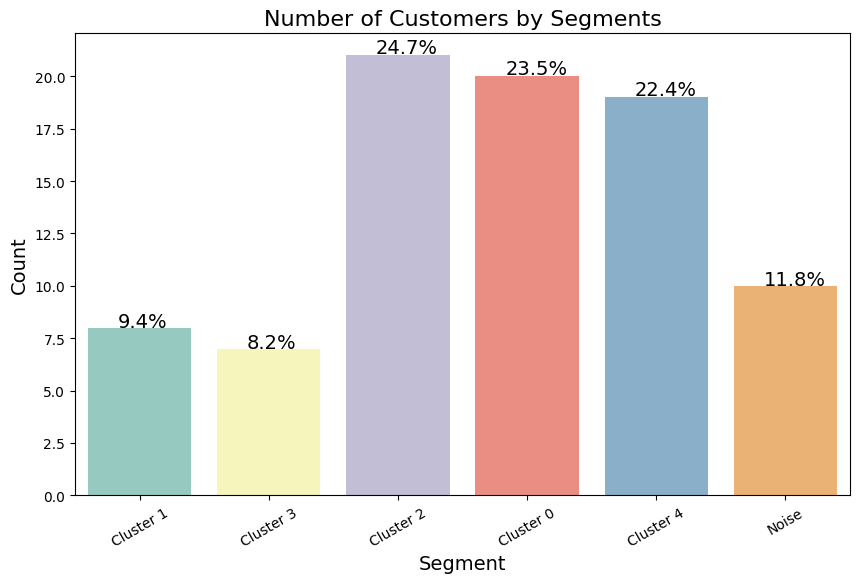

In [83]:
ratio_info(rfm, "HDBSCAN_Cluster")

In [84]:
print('Agglomerative Clustering RFM Model Evaluation '.center(70, '='))
X = rfm[['Recency', 'Frequency', 'Monetary']]
labels = rfm['HDBSCAN_Cluster']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

============Agglomerative Clustering RFM Model Evaluation ============
Number of Observations: 85
Number of Segments: 6
Silhouette Score: -0.262
Calinski Harabasz Score: 13.195
Davies Bouldin Score: 3.764 


## Combined RFM Scoring Clustering data analysis

In [85]:
rfm['RFM_Score'].value_counts()

RFM_Score
411    32
422    14
421    13
432     6
311     6
322     5
412     2
444     2
423     1
321     1
443     1
442     1
111     1
Name: count, dtype: int64

In [86]:
custom_segment_map = {
    '411': 'New Enthusiasts',
    r'42[2-3]': 'Moderately Engaged Customers',
    '421': 'Beginning Customers',
    '432': 'Future Big Customers',
    r'3[1-2]1': 'Disinterested Customers',
    '322': 'Stable Customers',
    '412': 'New Interested Parties',
    '444': 'Champions',
    r'44[2-3]': 'Loyal Customers',
    '111': 'Dormant'
}

rfm['RFM_Custom_Segment'] = rfm['RFM_Score'].replace(custom_segment_map, regex = True)
rfm['RFM_Custom_Segment'].value_counts()

RFM_Custom_Segment
New Enthusiasts                 32
Moderately Engaged Customers    15
Beginning Customers             13
Disinterested Customers          7
Future Big Customers             6
Stable Customers                 5
Loyal Customers                  2
Champions                        2
New Interested Parties           2
Dormant                          1
Name: count, dtype: int64

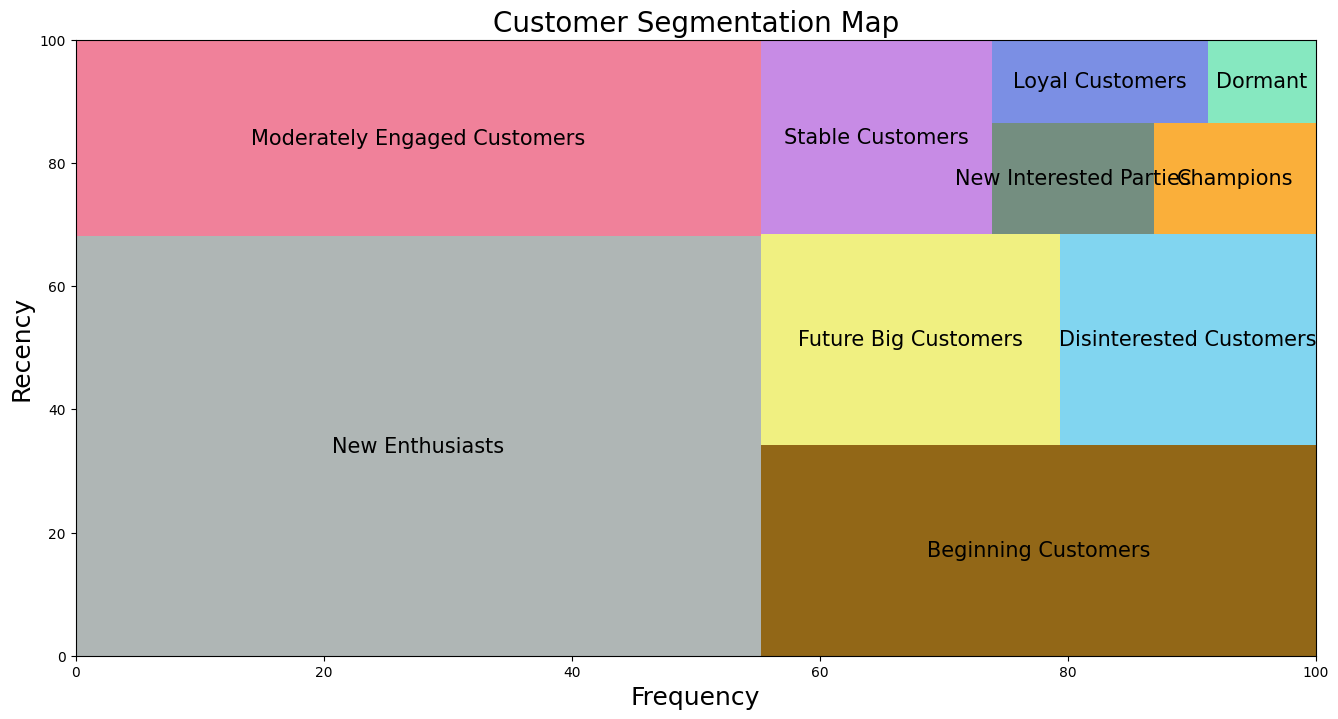

In [87]:
import squarify

segments = rfm["RFM_Custom_Segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 8)
squarify.plot(
    sizes=segments,
    label=[label for label in custom_segment_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

**Custom Segments and Descriptions**:

411: **New Enthusiasts**

- Characteristics:
    - High Recency (R = 4): Recently engaged or made their first purchase.
    - Low Frequency (F = 1): Limited number of purchases so far.
    - Low Monetary Value (M = 1): Minimal spending, likely testing the waters.

- Description:
Customers who recently interacted but have not yet shown strong engagement or spending patterns. They are in the early stages of their relationship with the company.

- Action:
Offer introductory discounts or exclusive promotions to encourage repeated purchases and higher spending.

423 or 422: **Moderately Engaged Customers**

- Characteristics:
    - High Recency (R = 4): Actively engaged in recent times.
    - Moderate Frequency (F = 2): Regular but not highly frequent purchasers.
    - Moderate Monetary Value (M = 2): Spend at an average level.

- Description:
Customers who are somewhat engaged, purchasing occasionally and contributing moderately to revenue.

- Action:
Introduce loyalty programs or bundle offers to increase their purchase frequency and spending.

421: **Beginning Customers**

- Characteristics:
    - High Recency (R = 4): Recently interacted with the company.
    - Moderate Frequency (F = 2): A few purchases made.
    - Low Monetary Value (M = 1): Small transaction amounts.

- Description:
New or emerging customers with limited spending but promising potential for growth.

- Action:
Focus on upselling and cross-selling strategies to increase their basket size and frequency.

432: **Future Big Customers**

- Characteristics:
    - High Recency (R = 4): Recently active and engaged.
    - Moderate-to-High Frequency (F = 3): Demonstrated regular purchasing habits.
    - Moderate Monetary Value (M = 2): Spend moderately but show potential for higher value.

- Description:
Customers who exhibit strong engagement and purchasing patterns, positioning them as potential high-value customers.

- Action:
Provide premium offerings or early access to new products to nurture their potential.

321 or 311: **Disinterested Customers**

- Characteristics:
    - Moderate Recency (R = 3): Their last interaction was not recent but not overly distant.
    - Low Frequency (F = 1): Rarely make purchases.
    - Low Monetary Value (M = 1): Spend minimal amounts.

- Description:
Customers who are losing interest and risk becoming inactive.

- Action:
Deploy reactivation campaigns with personalized offers or surveys to understand their lack of engagement.

322: **Stable Customers**

- Characteristics:
    - Moderate Recency (R = 3): Engaged periodically but not highly recently.
    - Moderate Frequency (F = 2): Make occasional purchases.
    - Moderate Monetary Value (M = 2): Spend at an average level.

- Description:
Steady customers who are consistent but not highly engaged. They provide a reliable revenue stream.

- Action:
Strengthen their loyalty with exclusive offers or memberships to enhance engagement.

412: **New Interested Parties**

- Characteristics:
    - High Recency (R = 4): Recently engaged with the brand.
    - Low Frequency (F = 1): Made very few purchases so far.
    - Moderate Monetary Value (M = 2): Show willingness to spend but are in early stages.

- Description:
New customers showing initial signs of interest and engagement with moderate spending capacity.

- Action:
Offer targeted content or introductory packages to build a stronger relationship and foster frequent engagement.

444: **Champions**

- Characteristics:
    - High Recency (R = 4): Regularly interact with the company.
    - High Frequency (F = 4): Purchase very often.
    - High Monetary Value (M = 4): Spend significantly.

- Description:
The most valuable customers who are loyal, frequent buyers and contribute heavily to revenue.

- Action:
Reward them with exclusive benefits, priority services, and personalized communications to retain loyalty.

442 or 443: **Loyal Customers**

- Characteristics:
    - High Recency (R = 4): Recently interacted.
    - High Frequency (F = 4): Very frequent buyers.
    - Moderate Monetary Value (M = 3): Spend at an average level.

- Description:
Highly frequent customers who maintain steady engagement but have room to grow their spending.

- Action:
Provide incentives to increase their spending, such as tiered loyalty rewards or targeted upsell campaigns.

111: **Dormant**

- Characteristics:
    - Low Recency (R = 1): Last purchase was a long time ago.
    - Low Frequency (F = 1): Rarely purchased.
    - Low Monetary Value (M = 1): Spend minimal amounts.

- Description:
Completely inactive customers who have disengaged.

- Action:
Re-engage them with special offers, nostalgia-driven marketing, or win-back campaigns.

In [88]:
print('RFM Model Evaluation '.center(70, '='))
X = rfm[['R_Score', 'F_Score', 'M_Score']]
labels = rfm['RFM_Custom_Segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

========================RFM Model Evaluation =========================
Number of Observations: 85
Number of Segments: 10
Silhouette Score: 0.921
Calinski Harabasz Score: 391.104
Davies Bouldin Score: 0.273 


- The Silhouette Score measures the similarity of a point to its own cluster compared to its distance to the nearest cluster. The value ranges from -1 to 1, Values close to 1 indicate that the points are well clustered and far from other clusters (good clusters). Values close to 0 indicate that the points are on the border between two clusters. Negative values indicate that the points may have been grouped incorrectly.
- A **Silhouette Score** of **0.921** is excellent and indicates that the clusters are well defined. Most of the points are well grouped, with little overlap between the clusters.


- Measure the separation between clusters and the cohesion within clusters. The Calinski-Harabasz Score is based on the ratio between the sum of the dispersion between the clusters and the sum of the dispersion within the clusters. The higher the value, the better the separation and cohesion of the clusters. Higher values indicate that the clusters are well separated and cohesive and smaller values indicate that the clusters are poorly defined.
- A **Calinski-Harabasz Score** of **391.104** is quite high, which suggests that the clusters are well separated and well defined, with a good overall structure.


- The Davies-Bouldin Score calculates the average of the similarity ratios between all pairs of clusters. The similarity between two clusters is the sum of the dispersion within each cluster divided by the distance between the cluster centers. The lower the value, the better the quality of the clusters (i.e. the less similarity between clusters and the more separated they are). Smaller values indicate more distinct and well-defined clusters and larger values indicate more similar clusters and therefore worse clustering.
- A **Davies-Bouldin Score** of **0.273** is very good, indicating that the clusters are well separated and distinct from each other.

# Best Clustering Algorithm Exploratory Data Analysis

### Geographical analysis of Customers segment

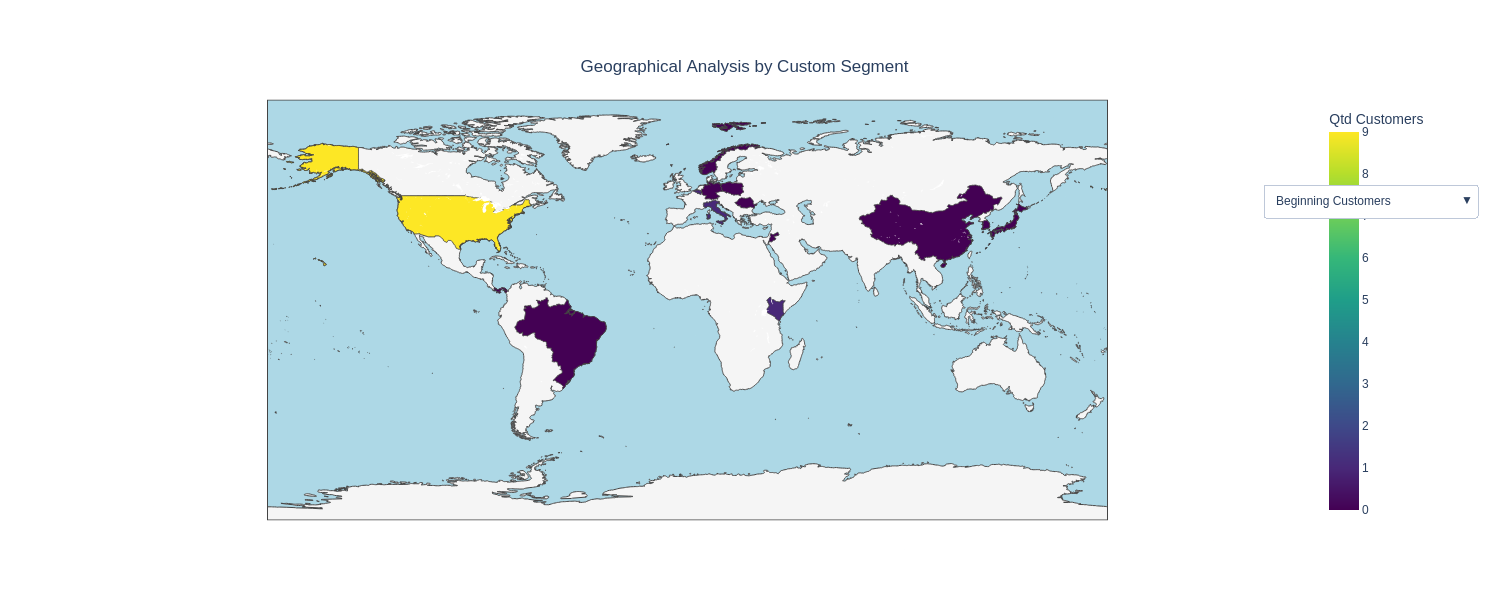

In [89]:
world_map = rfm.groupby(
    ['office_location', 'RFM_Custom_Segment']
).size().reset_index(name='count')

choropleth_data = world_map.pivot_table(
    index='office_location', 
    columns='RFM_Custom_Segment', 
    values='count', 
    fill_value=0
)

fig = go.Figure()

for segment in choropleth_data.columns:
    fig.add_trace(
        go.Choropleth(
            locations=choropleth_data.index,  # Nomes dos países
            locationmode='country names',
            z=choropleth_data[segment],  # Valores do segmento
            text=choropleth_data.index,  # Tooltip com os nomes dos países
            colorscale='Viridis',
            colorbar_title='Qtd Customers',
            visible=False  # Apenas um segmento será visível inicialmente
        )
    )

fig.data[0].visible = True

buttons = []
for i, segment in enumerate(choropleth_data.columns):
    buttons.append(dict(
        label=segment,
        method="update",
        args=[
            {"visible": [j == i for j in range(len(fig.data))]},  # Atualiza a visibilidade
            {"z": [choropleth_data[segment]]},  # Atualiza os valores de cor
            {"title": f"Geographical Analysis for {segment}"}  # Atualiza o título
        ]
    ))

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.15,
            y=0.8
        )
    ],
    title={
        'text': f"Geographical Analysis by Custom Segment",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    geo=dict(
        resolution=50,
        showocean=True,
        oceancolor="LightBlue",
        showland=True,
        landcolor="whitesmoke",
        showframe=True
    ),
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

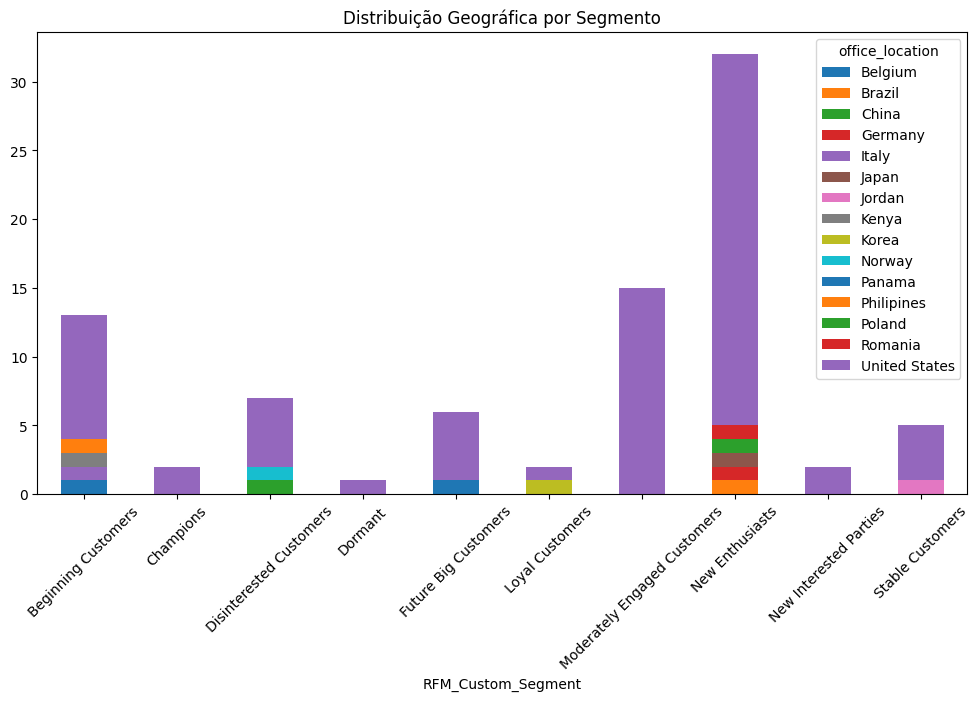

In [90]:
segment_geography = rfm.groupby(['RFM_Custom_Segment', 'office_location']).size().unstack()
segment_geography.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title("Distribuição Geográfica por Segmento")
plt.xticks(rotation=45)
plt.show()

We can notice that New enthusiasts is the segment with the most variability of different country customers 

## Product Acceptance by Group

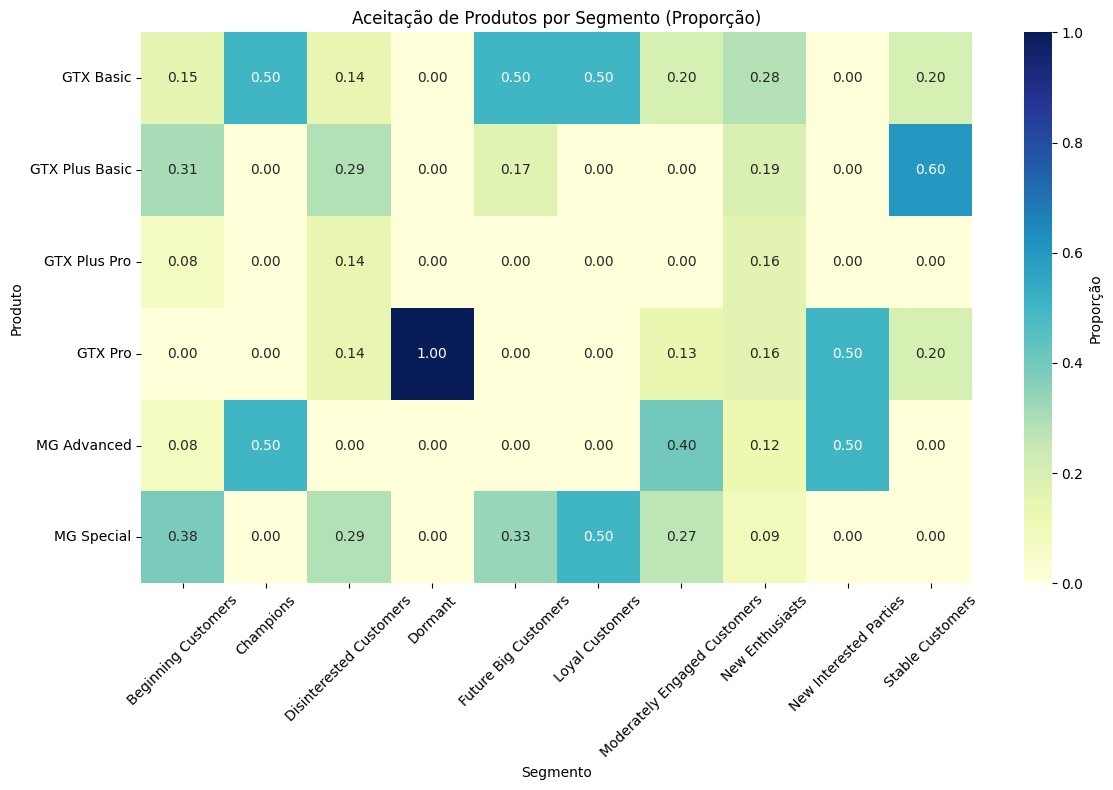

In [91]:
product_segment = rfm.groupby(['RFM_Custom_Segment', 'product']).size().reset_index(name='count')

product_segment_pivot = product_segment.pivot_table(
    index='product', 
    columns='RFM_Custom_Segment', 
    values='count', 
    fill_value=0
)

product_segment_normalized = product_segment_pivot.div(product_segment_pivot.sum(axis=0), axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(product_segment_normalized, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proporção'})
plt.title('Aceitação de Produtos por Segmento (Proporção)')
plt.xlabel('Segmento')
plt.ylabel('Produto')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Revenue analysis by segment

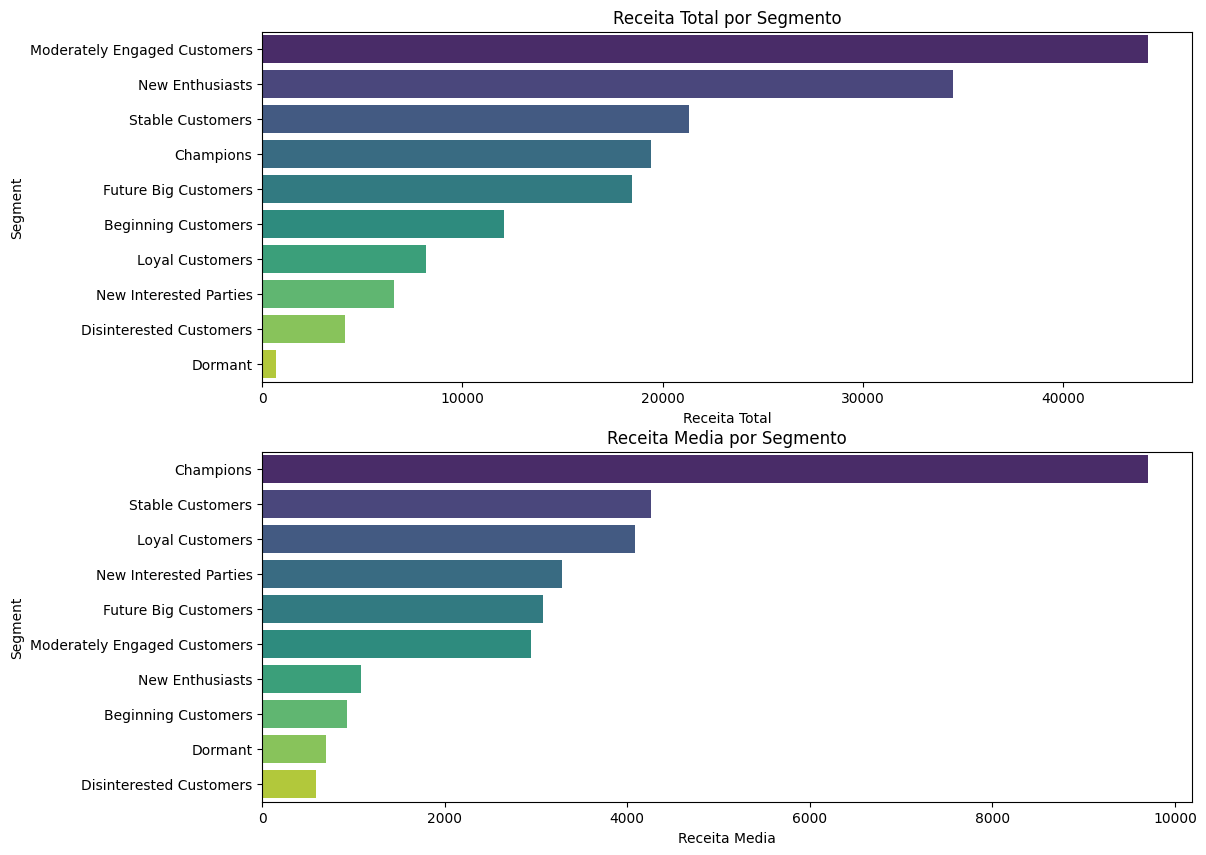

In [92]:
total_segment_revenue = rfm.groupby('RFM_Custom_Segment')['revenue'].sum().reset_index()
total_segment_revenue = total_segment_revenue.sort_values(by='revenue', ascending=False)

average_segment_revenue = rfm.groupby('RFM_Custom_Segment')['revenue'].mean().reset_index()
average_segment_revenue = average_segment_revenue.sort_values(by='revenue', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(y='RFM_Custom_Segment', x='revenue', data=total_segment_revenue, palette='viridis', orient='h', ax=ax1)
ax1.set_title('Receita Total por Segmento')
ax1.set_xlabel('Receita Total')
ax1.set_ylabel('Segment')

sns.barplot(y='RFM_Custom_Segment', x='revenue', data=average_segment_revenue, palette='viridis', orient='h', ax=ax2)
ax2.set_title('Receita Media por Segmento')
ax2.set_xlabel('Receita Media')
ax2.set_ylabel('Segment')
plt.show()

In [93]:
low_revenue_segments = average_segment_revenue[average_segment_revenue['revenue'] < average_segment_revenue['revenue'].mean()]
print("Segmentos menos lucrativos que podem ser otimizados:")
low_revenue_segments

Segmentos menos lucrativos que podem ser otimizados:


,RFM_Custom_Segment,revenue
6,Moderately Engaged Customers,2947.649333
7,New Enthusiasts,1078.109062
0,Beginning Customers,928.705385
3,Dormant,702.720000
2,Disinterested Customers,590.870000


## Ratio of Customers by Segments

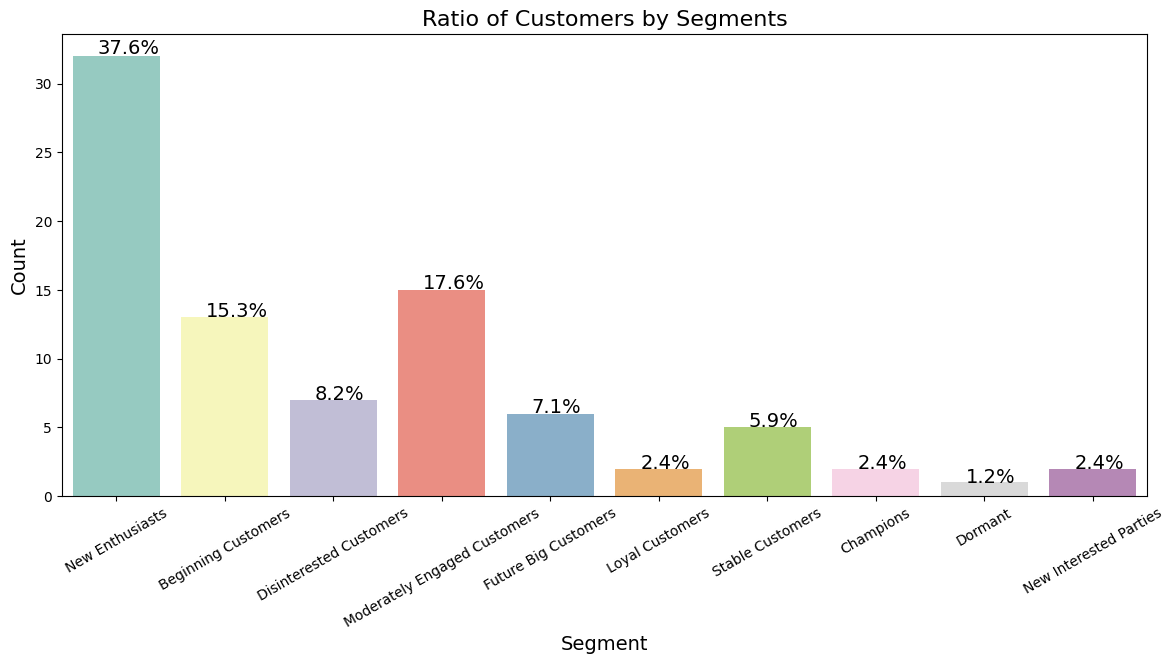

In [94]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(data = rfm,
                   x = 'RFM_Custom_Segment',
                   palette = 'Set3')
total = len(rfm['RFM_Custom_Segment'])
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Ratio of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(rotation=30)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

## Custumers Segment by RFM

/tmp/ipykernel_21441/4145280401.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_21441/4145280401.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_21441/4145280401.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



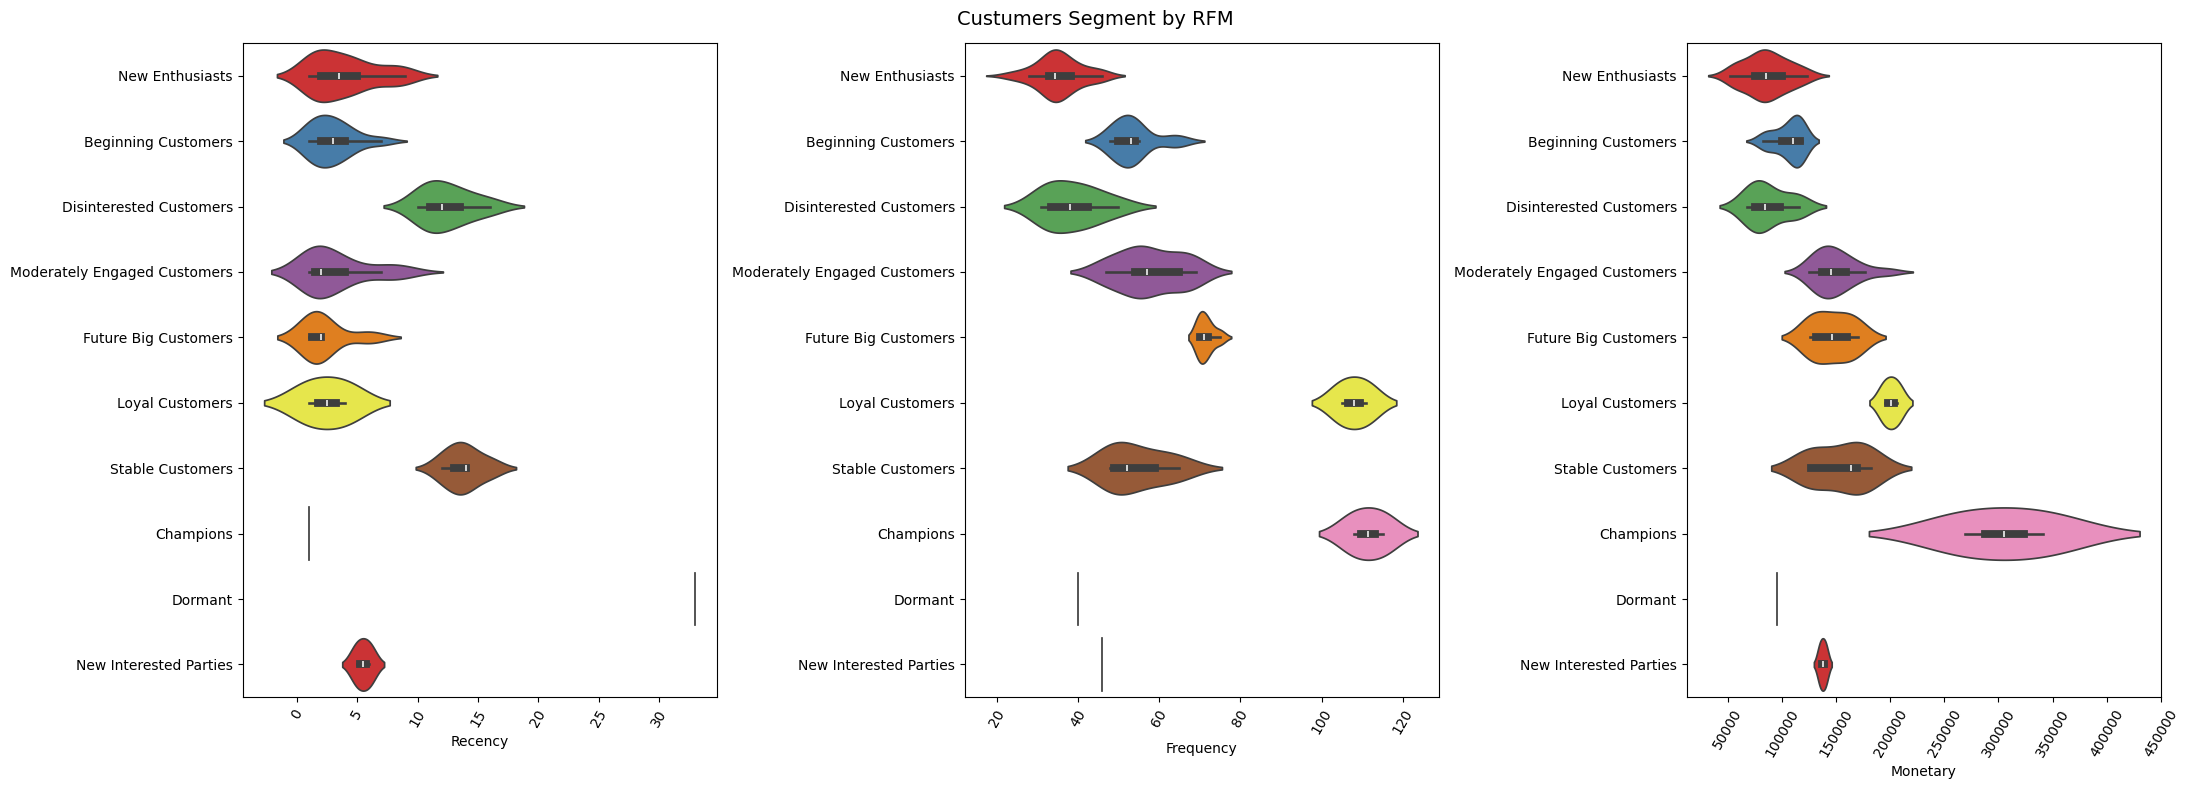

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle("Custumers Segment by RFM", size=14)
feature_list = ['Recency', 'Frequency', 'Monetary']
for idx, col in enumerate(feature_list):
    sns.violinplot(
        ax=axes[idx], data=rfm, y="RFM_Custom_Segment", x=feature_list[idx], orient='h', palette='Set1'
    )
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    axes[idx].set_ylabel("")
    
plt.tight_layout()
plt.show()

## Expanding RFM metrics for Statiscal segment analysis

### Actual Customer Lifetime Value (CLTV) 
Total value each customer has brought over the course of all purchases with a discount rate for inflation exclusion. Combining this with RFM metrics can help to identify the most valuable customers.

Actual_CLTV = $\frac{Monetary}{(1+discount\_rate)Months\_Since\_Start}$

<Axes: xlabel='Actual_CLTV', ylabel='Count'>

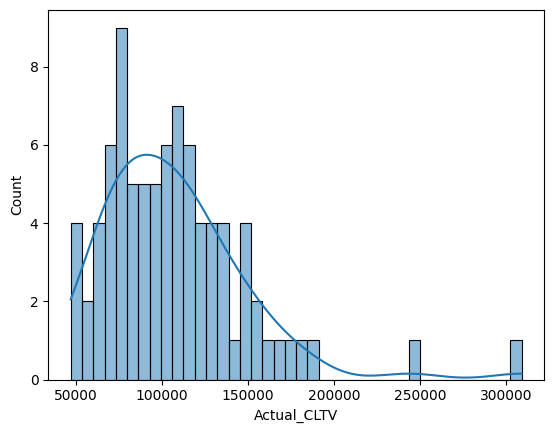

In [96]:
discount_rate = 0.01 # Monthy inflation (simulation)
observation_start = rfm['first_purchase'].min()

rfm['Months_Since_Start'] = ((rfm['last_purchase'] - observation_start).dt.days / 30).astype(int)
rfm['Actual_CLTV'] = rfm['Monetary'] / ((1 + discount_rate) ** rfm['Months_Since_Start'])

cltv_discounted = rfm.groupby('account')['Actual_CLTV'].sum().reset_index()
sns.histplot(cltv_discounted['Actual_CLTV'], bins=40, kde=True)

### Recency to Frequency Ratio (R/F Ratio)
A customer with high frequency and low recency may be more engaged than a customer with high recency and low frequency.

In [97]:
rfm['RF_Ratio'] = rfm['Recency'] / (rfm['Frequency'] + 1)

<Axes: xlabel='RF_Ratio', ylabel='Count'>

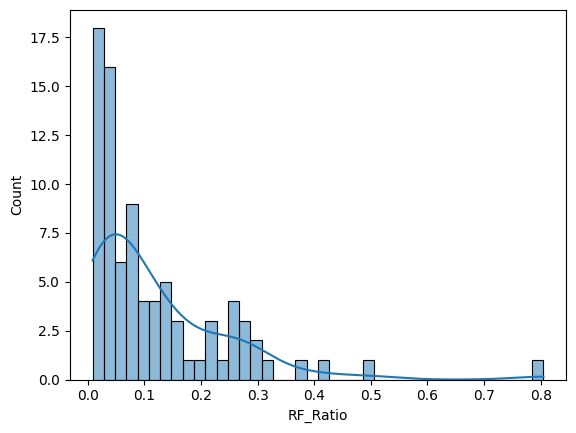

In [98]:
sns.histplot(rfm['RF_Ratio'], bins=40, kde=True)

### Average Transaction Value (ATV)
Shows how much customers spend on average per purchase.

In [99]:
rfm['ATV'] = rfm['Monetary'] / rfm['Frequency']

<Axes: xlabel='ATV', ylabel='Count'>

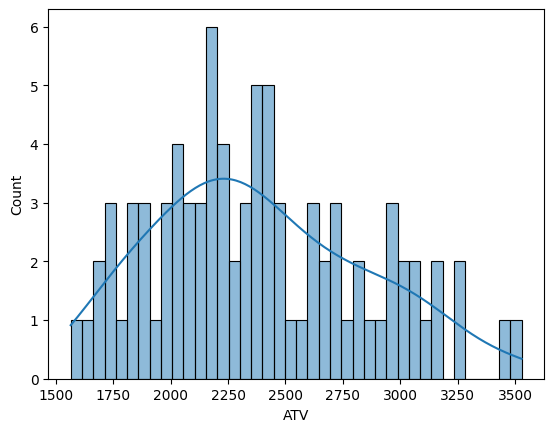

In [100]:
sns.histplot(rfm['ATV'], bins=40, kde=True)

### Engagement Score
Show customers based on metrics such as Recency, Frequency and Monetary. Customers with low scores may be at greater risk of churn.

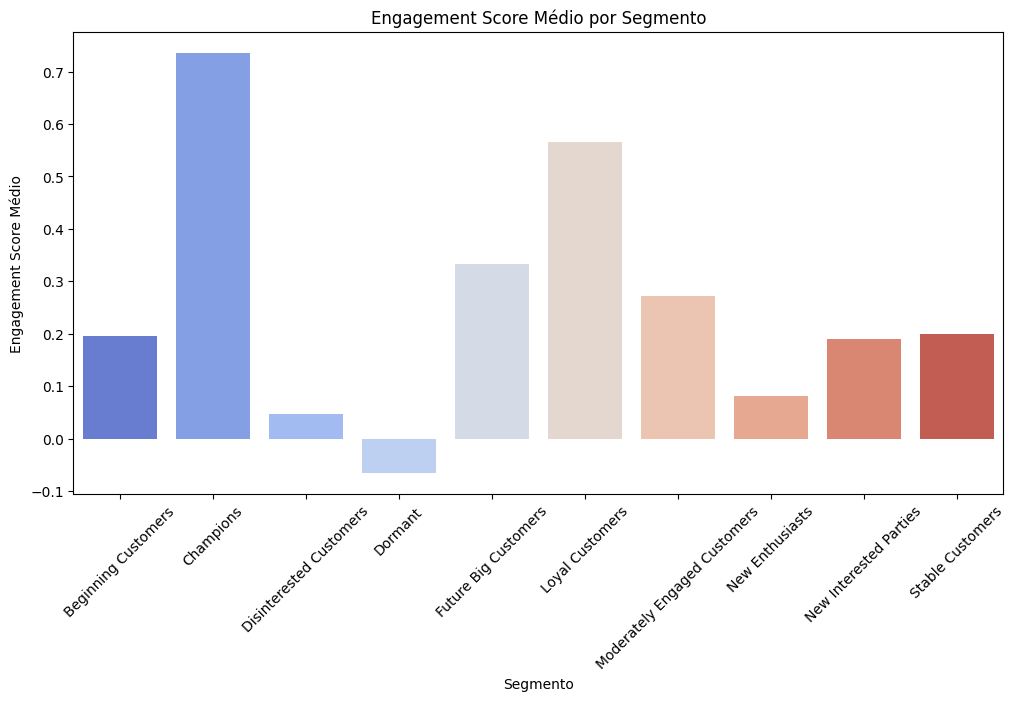

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

rfm['engagement_score'] = rfm_scaled[:, 1] * 0.4 + rfm_scaled[:, 2] * 0.4 - rfm_scaled[:, 0] * 0.2

engagement_by_segment = rfm.groupby('RFM_Custom_Segment')['engagement_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='RFM_Custom_Segment', y='engagement_score', data=engagement_by_segment, palette='coolwarm')
plt.title('Engagement Score Médio por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Engagement Score Médio')
plt.xticks(rotation=45)
plt.show()

### Descritive Statistics metrics from Recency, Frequency, Monetary, LTV, RF Ratio, ATV and Engagement Score

In [102]:
summary_table = rfm[['Recency', 'Monetary', 'Frequency', 'RFM_Custom_Segment', 'Actual_CLTV', 'RF_Ratio', 'ATV', 'engagement_score']]\
.groupby('RFM_Custom_Segment')\
.agg({'mean','std', 'median', 'max','min'})

styled_table = summary_table.style.format({
    'mean': '{:.2f}',
    'std': '{:.2f}',
    'max': '{:.2f}',
    'min': '{:.2f}'
})

styled_table

# CLTV (Customer Lifetime Value)

1. Incluir apenas oportunidades vencedoras (Won)
    Vantagens:
    - Foco nos clientes que geraram receita.
    - Métricas de frequência, recency, e monetary value refletem melhor o comportamento dos clientes que geraram valor financeiro.
    - O CLTV será mais realista em termos de retorno financeiro esperado.
        
    Desvantagens:
    - Ignora padrões de comportamento dos clientes que começaram negociações, mas não fecharam. Isso pode levar a uma visão incompleta do ciclo de vida do cliente.

2. Incluir todas as oportunidades (Won e Lost)
    Vantagens:
    - Captura uma visão mais ampla do comportamento dos clientes, incluindo o número de negociações não convertidas.
    - Pode ser útil para entender o esforço comercial total e como ele se reflete em taxas de conversão e CLTV.
    
    Desvantagens:
    - Pode distorcer as métricas:
        - Frequência pode aumentar, mas sem correspondência monetária real.
        - Monetary value diminui (as Lost sempre têm um valor monetário de 0).
        - O CLTV pode ser subestimado, já que será diluído por oportunidades não convertidas.

### Building Summary data from Transaction data for Model fitting

In [103]:
df_lost = df[df['deal_stage'] == 'Lost']
df_won = df[df['deal_stage'] == 'Won']

In [104]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
    df_won,
    customer_id_col='account',
    datetime_col='close_date',
    monetary_value_col='close_value',
    observation_period_end=today_date,
    # include_first_transaction=True
)

In [105]:
df_won.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4238 entries, 0 to 7211
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   opportunity_id                 4238 non-null   object        
 1   sales_agent                    4238 non-null   object        
 2   product                        4238 non-null   object        
 3   account                        4238 non-null   object        
 4   deal_stage                     4238 non-null   object        
 5   engage_date                    4238 non-null   datetime64[ns]
 6   close_date                     4238 non-null   datetime64[ns]
 7   close_value                    4238 non-null   float64       
 8   sector                         4238 non-null   object        
 9   year_established               4238 non-null   object        
 10  revenue                        4238 non-null   float64       
 11  employees             

## Building BG-NBD model

In [106]:
bgf = BetaGeoFitter(penalizer_coef=0.005)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
bgf.params_

r        5.045242e+00
alpha    3.419723e+01
a        9.603632e-29
b        5.249199e-16
dtype: float64

### Model prediction 

In [107]:
summary['prob_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_day'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    1, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_week'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    7, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_monthly'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_bimonthly'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    61, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_trimester'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    92, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_half_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    182, summary['frequency'], summary['recency'], summary['T']
)

summary['expected_purchases_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    365, summary['frequency'], summary['recency'], summary['T']
)

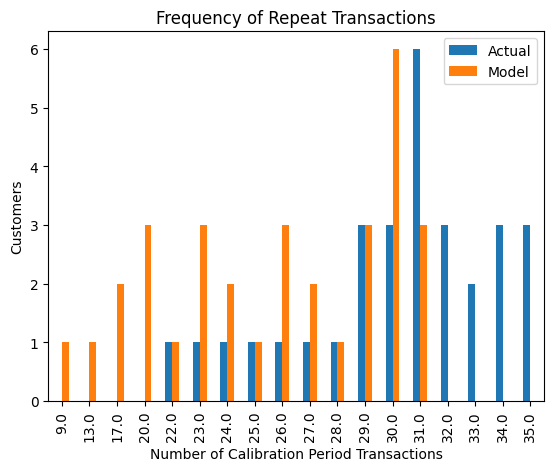

In [108]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, max_frequency=14)
plt.show()

## Building GammaGammaFitter model

In [109]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['frequency'], summary['monetary_value'])

summary['expected_average_profit'] = ggf.conditional_expected_average_profit(
    summary['frequency'], summary['monetary_value']
)

## CLTV prediction

In [110]:
summary['Predicted_Year_CLTV'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12,  # Monthly
    discount_rate=0.01,  # Monthly discount
)

summary['Predicted_Year_CLTV'].sort_values(ascending = False)

account
Kan-code      354798.482528
Konex         285678.410436
Cheers        219641.331049
Condax        218436.534924
Hottechi      205498.449733
                  ...      
Sumace         68376.756151
Donware        67937.588872
Zathunicon     67806.664650
Zoomit         60547.768149
Golddex        59853.031778
Name: Predicted_Year_CLTV, Length: 85, dtype: float64

### Year CLTV Segmentation

In [111]:
summary['Predicted_CLTV_Segment'] = pd.qcut(summary['Predicted_Year_CLTV'], q=3, labels=['Low', 'Medium', 'High'])
summary[['Predicted_CLTV_Segment', 'Predicted_Year_CLTV']].head(15)

,Predicted_CLTV_Segment,Predicted_Year_CLTV
account,,
Acme Corporation,Medium,119003.454178
Betasoloin,Medium,106019.123725
Betatech,Medium,120905.100831
Bioholding,Low,103975.876666
Bioplex,Low,81276.901848
Blackzim,Low,101110.562252
Bluth Company,Low,85597.482157
Bubba Gump,Medium,107359.282826
Cancity,Medium,129417.775100


<Axes: xlabel='Predicted_Year_CLTV', ylabel='Count'>

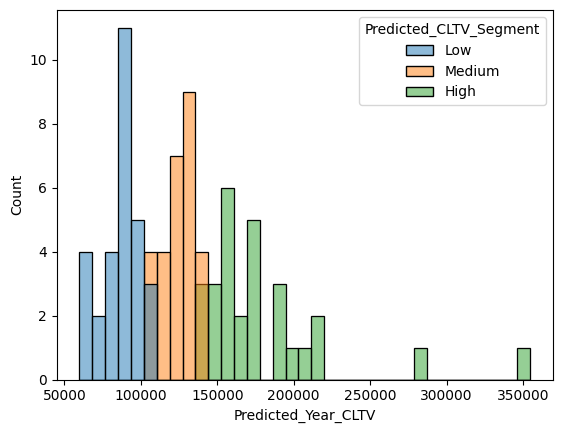

In [112]:
sns.histplot(x=summary['Predicted_Year_CLTV'], hue=summary['Predicted_CLTV_Segment'], bins=35)

# Exporting DataFrames

In [123]:
print(rfm.columns)
rfm.head()

Index(['account', 'first_purchase', 'last_purchase', 'Recency', 'Frequency',
       'Monetary', 'office_location', 'product', 'revenue', 'R_Score',
       'F_Score', 'M_Score', 'RFM_Score', 'Kmeans_Cluster', 'Agg_Cluster',
       'HDBSCAN_Cluster', 'RFM_Custom_Segment', 'Months_Since_Start',
       'Actual_CLTV', 'RF_Ratio', 'ATV', 'engagement_score'],
      dtype='object')


,account,first_purchase,last_purchase,Recency,Frequency,Monetary,office_location,product,revenue,R_Score,...,RFM_Score,Kmeans_Cluster,Agg_Cluster,HDBSCAN_Cluster,RFM_Custom_Segment,Months_Since_Start,Actual_CLTV,RF_Ratio,ATV,engagement_score
0,Acme Corporation,2017-03-01,2017-12-27,5,34,101744.0,United States,GTX Basic,1100.04,4,...,411,0,0,Cluster 1,New Enthusiasts,10,92107.515918,0.142857,2992.470588,0.091988
1,Betasoloin,2017-03-01,2017-12-28,4,34,97036.0,United States,GTX Plus Pro,251.41,4,...,411,0,0,Cluster 1,New Enthusiasts,10,87845.424936,0.114286,2854.000000,0.091741
2,Betatech,2017-03-08,2017-12-29,3,53,107408.0,Kenya,GTX Plus Pro,647.18,4,...,421,2,2,Cluster 3,Beginning Customers,10,97235.061230,0.055556,2026.566038,0.194914
3,Bioholding,2017-03-10,2017-12-28,4,50,90991.0,Philipines,MG Special,587.34,4,...,421,0,2,Cluster 2,Beginning Customers,10,82372.965294,0.078431,1819.820000,0.152963
4,Bioplex,2017-03-04,2017-12-16,16,31,67393.0,United States,MG Special,326.82,3,...,311,1,0,Cluster 0,Disinterested Customers,9,61620.103775,0.500000,2173.967742,-0.037215


In [125]:
rfm_to_merge = rfm.drop(columns=['product', 'revenue', 'Kmeans_Cluster', 'Agg_Cluster',
       'HDBSCAN_Cluster', 'Months_Since_Start', 'office_location'])
rfm_to_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account             85 non-null     object        
 1   first_purchase      85 non-null     datetime64[ns]
 2   last_purchase       85 non-null     datetime64[ns]
 3   Recency             85 non-null     int64         
 4   Frequency           85 non-null     int64         
 5   Monetary            85 non-null     float64       
 6   R_Score             85 non-null     category      
 7   F_Score             85 non-null     category      
 8   M_Score             85 non-null     category      
 9   RFM_Score           85 non-null     object        
 10  RFM_Custom_Segment  85 non-null     object        
 11  Actual_CLTV         85 non-null     float64       
 12  RF_Ratio            85 non-null     float64       
 13  ATV                 85 non-null     float64       
 

In [126]:
print(df_won.info())
df_won.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4238 entries, 0 to 7211
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   opportunity_id                 4238 non-null   object        
 1   sales_agent                    4238 non-null   object        
 2   product                        4238 non-null   object        
 3   account                        4238 non-null   object        
 4   deal_stage                     4238 non-null   object        
 5   engage_date                    4238 non-null   datetime64[ns]
 6   close_date                     4238 non-null   datetime64[ns]
 7   close_value                    4238 non-null   float64       
 8   sector                         4238 non-null   object        
 9   year_established               4238 non-null   object        
 10  revenue                        4238 non-null   float64       
 11  employees             

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,...,office_location,subsidiary_of,series,sales_price,manager,regional_office,sales_cycle_duration,agent_close_rate,opportunities_per_account,opportunities_per_sales_agent
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001,...,United States,NaN,GTX,1096,Dustin Brinkmann,Central,132.0,66.153846,101,216
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002,...,United States,NaN,GTX,4821,Melvin Marxen,Central,137.0,63.110307,119,613
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001,...,United States,NaN,MG,55,Melvin Marxen,Central,133.0,63.110307,101,613
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998,...,United States,Acme Corporation,GTX,550,Dustin Brinkmann,Central,135.0,66.153846,121,216
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982,...,United States,NaN,GTX,550,Summer Sewald,West,128.0,61.685824,87,290


In [116]:
print(summary.columns)
summary.head()

Index(['frequency', 'recency', 'T', 'monetary_value', 'prob_alive',
       'expected_purchases_day', 'expected_purchases_week',
       'expected_purchases_monthly', 'expected_purchases_bimonthly',
       'expected_purchases_trimester', 'expected_purchases_half_year',
       'expected_purchases_year', 'expected_average_profit',
       'Predicted_Year_CLTV', 'Predicted_CLTV_Segment'],
      dtype='object')


,frequency,recency,T,monetary_value,prob_alive,expected_purchases_day,expected_purchases_week,expected_purchases_monthly,expected_purchases_bimonthly,expected_purchases_trimester,expected_purchases_half_year,expected_purchases_year,expected_average_profit,Predicted_Year_CLTV,Predicted_CLTV_Segment
account,,,,,,,,,,,,,,,
Acme Corporation,29.0,301.0,306.0,3489.241379,1.0,0.100075,0.700525,3.002250,6.104576,9.206901,18.213652,36.527379,3521.795835,119003.454178,Medium
Betasoloin,31.0,302.0,306.0,2937.806452,1.0,0.105954,0.741678,3.178619,6.463191,9.747764,19.283620,38.673193,2963.447913,106019.123725,Medium
Betatech,48.0,296.0,299.0,2236.625000,1.0,0.159201,1.114405,4.776022,9.711244,14.646467,28.974533,58.108266,2249.209092,120905.100831,Medium
Bioholding,44.0,293.0,297.0,2066.772727,1.0,0.148085,1.036593,4.442541,9.033167,13.623792,26.951415,54.050915,2079.470026,103975.876666,Low
Bioplex,26.0,287.0,303.0,2587.500000,1.0,0.092068,0.644479,2.762055,5.616178,8.470302,16.756466,33.605001,2614.486179,81276.901848,Low


In [127]:
summary_to_merge = summary.drop(columns=['frequency', 'recency', 'monetary_value'])
summary_to_merge.reset_index(inplace=True)
summary_to_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   account                       85 non-null     object  
 1   T                             85 non-null     float64 
 2   prob_alive                    85 non-null     float64 
 3   expected_purchases_day        85 non-null     float64 
 4   expected_purchases_week       85 non-null     float64 
 5   expected_purchases_monthly    85 non-null     float64 
 6   expected_purchases_bimonthly  85 non-null     float64 
 7   expected_purchases_trimester  85 non-null     float64 
 8   expected_purchases_half_year  85 non-null     float64 
 9   expected_purchases_year       85 non-null     float64 
 10  expected_average_profit       85 non-null     float64 
 11  Predicted_Year_CLTV           85 non-null     float64 
 12  Predicted_CLTV_Segment        85 non-null     catego

In [118]:
export_dataset = (pd.merge(
    pd.merge(
        df_won, rfm_to_merge, on='account', how='inner'
    ), summary_to_merge, on='account', how='inner')
)

In [119]:
print(export_dataset.info())
export_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   opportunity_id                 4238 non-null   object        
 1   sales_agent                    4238 non-null   object        
 2   product                        4238 non-null   object        
 3   account                        4238 non-null   object        
 4   deal_stage                     4238 non-null   object        
 5   engage_date                    4238 non-null   datetime64[ns]
 6   close_date                     4238 non-null   datetime64[ns]
 7   close_value                    4238 non-null   float64       
 8   sector                         4238 non-null   object        
 9   year_established               4238 non-null   object        
 10  revenue                        4238 non-null   float64       
 11  employees        

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,...,expected_purchases_day,expected_purchases_week,expected_purchases_monthly,expected_purchases_bimonthly,expected_purchases_trimester,expected_purchases_half_year,expected_purchases_year,expected_average_profit,Predicted_Year_CLTV,Predicted_CLTV_Segment
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001,...,0.158864,1.112051,4.765933,9.690731,14.615528,28.913328,57.985520,2412.667623,129417.775100,Medium
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002,...,0.173562,1.214933,5.206854,10.587269,15.967685,31.588247,63.350055,2955.439731,173199.239921,High
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001,...,0.158864,1.112051,4.765933,9.690731,14.615528,28.913328,57.985520,2412.667623,129417.775100,Medium
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998,...,0.205896,1.441272,6.176879,12.559655,18.942430,37.473068,75.152032,2087.026157,145092.679086,High
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982,...,0.126903,0.888323,3.807098,7.741100,11.675102,23.096397,46.319698,3112.094860,133350.737821,Medium


In [120]:
export_dataset.to_json('../data/won_stage_enriched_data.json')